# Imports


In [1]:
# System and OS utilities
import os
from collections import defaultdict
from google.colab import drive

# Data manipulation and processing
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import (
    ResNet50, EfficientNetB0, InceptionV3, InceptionResNetV2, DenseNet121
)
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M

# Scikit-learn for data preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Image processing
from PIL import Image

# Utility libraries
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
drive.mount('/content/drive')

# Load the images
data_dir = '/content/drive/MyDrive/Expanded_HHD_AgeSplit'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load the CSV file
csv_dir = os.path.join(data_dir, 'NewAgeSplit.csv')
labels_data = pd.read_csv(csv_dir)

Mounted at /content/drive


In [4]:
BATCH_SIZE = 128

# Training


## Loading Images and Preprocessing


In [5]:
def calculate_resized_dimensions(height, width, patch_size=400, stride=200, standard_size=800):
    """
    Calculates resized dimensions to maintain aspect ratio, be compatible with patching, and close to a standard size.

    Args:
        height (int): Original height of the image.
        width (int): Original width of the image.
        patch_size (int): Size of each patch (default 400).
        stride (int): Stride for patching (default 200).
        standard_size (int): Target standard size for the smaller dimension.

    Returns:
        tuple: Resized height and width.
    """
    aspect_ratio = width / height

    # Scale dimensions such that the smaller side matches the standard size
    if height < width:
        new_height = standard_size
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = standard_size
        new_height = int(new_width / aspect_ratio)

    # Adjust dimensions to be compatible with patching
    def adjust_dimension(dim):
        remainder = (dim - patch_size) % stride
        return dim if remainder == 0 else dim - remainder

    new_height = adjust_dimension(new_height)
    new_width = adjust_dimension(new_width)

    return new_height, new_width

In [6]:
def read_tiff_image_with_dynamic_resize(img_path):
    """
    Reads a TIFF image, dynamically resizes it to be compatible with patches and standard size, and normalizes it.

    Args:
        img_path (tf.Tensor): Path to the image file.

    Returns:
        np.ndarray: Resized and normalized image as a NumPy array.
    """
    img = Image.open(img_path.numpy().decode("utf-8"))  # Load TIFF file
    img = img.convert('RGB')  # Convert to RGB if necessary
    original_size = img.size  # Original dimensions (width, height)
    new_height, new_width = calculate_resized_dimensions(original_size[1], original_size[0])
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Resize dynamically with LANCZOS
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
    return img_array

In [7]:
def process_image(row, data_dir, patch_size, step_size):
    """
    Processes a row to load the corresponding image, extract patches, and assign labels.

    Args:
        row (dict): Dictionary containing file path and label data.
        data_dir (str): Directory containing the images.
        patch_size (tuple): Size of each patch (height, width).
        step_size (int): Step size for extracting patches.

    Returns:
        tuple: Patches and corresponding labels.
    """
    img_path = tf.strings.join([data_dir, row['File']], separator='/')

    try:
        img = tf.py_function(func=read_tiff_image_with_dynamic_resize, inp=[img_path], Tout=tf.float32)
        img.set_shape([None, None, 3])
    except Exception as e:
        tf.print(f"Error processing file: {img_path}", e)
        raise e

    patches = tf.image.extract_patches(
        images=tf.expand_dims(img, 0),
        sizes=[1, patch_size[0], patch_size[1], 1],
        strides=[1, step_size, step_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patches = tf.reshape(patches, [-1, patch_size[0], patch_size[1], 3])
    labels = tf.fill([tf.shape(patches)[0]], row['Age'])

    return patches, labels

In [8]:
# Create the RandomRotation layer outside the augmentation function.
rotation_layer = tf.keras.layers.RandomRotation(factor=0.04167)

def advanced_augmentation(image, label):
    # Apply random rotation using the pre-instantiated layer.
    image = rotation_layer(image, training=True)

    # Random Zoom: Scale the image by a factor between 0.9 and 1.1.
    orig_shape = tf.shape(image)[:2]
    zoom_factor = tf.random.uniform([], 0.9, 1.1)
    new_size = tf.cast(tf.cast(orig_shape, tf.float32) * zoom_factor, tf.int32)
    image = tf.image.resize(image, new_size)
    # Crop or pad back to the original dimensions.
    image = tf.image.resize_with_crop_or_pad(image, orig_shape[0], orig_shape[1])

    # Random Brightness: Adjust brightness by a delta up to 0.1.
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Gaussian Noise: Add noise with a standard deviation of 0.05.
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [9]:
def patch_data_tf_dataset(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset for loading and preprocessing images, including patch extraction.

    Args:
        data_dir (str): Directory containing the images.
        labels_df (pd.DataFrame): DataFrame with file paths and labels.
        dataset_type (str): Subset type ('train', 'val', 'test').
        patch_size (tuple): Size of each patch (height, width).
        step_size (int): Step size for extracting patches.
        batch_size (int): Number of samples per batch.
        augment (bool): Whether to apply data augmentation.

    Returns:
        tf.data.Dataset: A TensorFlow dataset for training or evaluation.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process each row
    dataset = dataset.map(
        lambda row: process_image(row, data_dir, patch_size, step_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield patches
    dataset = dataset.flat_map(
        lambda patches, labels: tf.data.Dataset.zip(
            (tf.data.Dataset.from_tensor_slices(patches), tf.data.Dataset.from_tensor_slices(labels))
        )
    )

    # Apply augmentation if needed
    if augment:
        # Apply our advanced augmentation instead of just flipping.
        dataset = dataset.map(
            lambda patch, label: advanced_augmentation(patch, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

## Train

In [ ]:
# Define a function to create models using SOTA architectures
def build_sota_model(base_model_fn, input_shape=(400, 400, 3), dropout_rate=0.5):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression output

    model = Model(inputs, outputs)
    return model

In [ ]:
# Training generator with augmentation
train_dataset = patch_data_tf_dataset(
    data_dir=train_dir,
    labels_df=labels_data,
    dataset_type='train',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=True  # Enable augmentation
)

# Validation generator without augmentation
val_dataset = patch_data_tf_dataset(
    data_dir=val_dir,
    labels_df=labels_data,
    dataset_type='val',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

In [ ]:
training_dir = os.path.join(data_dir, 'ensemble_training')

# Define SOTA models
models = {
    'ResNet50': build_sota_model(ResNet50),
    'DenseNet121': build_sota_model(DenseNet121),
    'InceptionV3': build_sota_model(InceptionV3),
    'InceptionResNetV2': build_sota_model(InceptionResNetV2),
    'EfficientNetV2M': tf.keras.models.load_model(EfficientNetV2M)
}

trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{training_dir}/{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    # Unfreeze and fine-tune the base model
    model.layers[1].trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,  # Short fine-tuning
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    trained_models[model_name] = model


Training EfficientNetV2M...
Epoch 1/10
    194/Unknown 486s 1s/step - loss: 359.8981 - mae: 11.6081   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


194/194 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - loss: 358.7223 - mae: 11.5845 - val_loss: 104.3974 - val_mae: 8.7733 - learning_rate: 1.0000e-04
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 109s 555ms/step - loss: 155.3051 - mae: 9.8877 - val_loss: 105.8231 - val_mae: 8.9363 - learning_rate: 1.0000e-04
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 115s 589ms/step - loss: 149.3444 - mae: 9.5904 - val_loss: 101.5898 - val_mae: 8.6495 - learning_rate: 1.0000e-04
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 109s 559ms/step - loss: 146.3678 - mae: 9.5235 - val_loss: 105.7173 - val_mae: 8.8919 - learning_rate: 1.0000e-04
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 108s 552ms/step - loss: 146.6564 - mae: 9.5556 - val_loss: 121.4050 - val_mae: 9.6409 - learning_rate: 1.0000e-04
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 109s 556ms/step - loss: 145.5530 - mae: 9.4548 - val_loss: 121.4645 - val_mae: 9.7712 - learning_rate: 1.0000e-04
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 109s 556ms/step - loss: 155.0342 - mae: 9.6938 - 

# Evaluation


## Methods

In [10]:
def process_row_with_id(row):
    """
    Processes a row to generate patches, labels, and use 'File' as the ImageID.
    """
    # Load patches and labels
    patches, labels = process_image(row, test_dir, (400,400), 200)

    # Use 'File' as the ImageID
    image_id = tf.fill([tf.shape(patches)[0]], row['File'])
    return patches, labels, image_id

In [11]:
def patch_data_tf_dataset_with_ids(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset with patches and 'File' as ImageID.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process rows
    dataset = dataset.map(
        process_row_with_id,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield individual patches
    dataset = dataset.flat_map(
        lambda patches, labels, image_id: tf.data.Dataset.zip(
            (
                tf.data.Dataset.from_tensor_slices(patches),
                tf.data.Dataset.from_tensor_slices(labels),
                tf.data.Dataset.from_tensor_slices(image_id) # Keep image_id here
            )
        )
    )

    # Apply augmentation if required
    if augment:
        dataset = dataset.map(
            lambda patch, label, image_id: (tf.image.random_flip_left_right(patch), label, image_id),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_evaluation_metrics(true_images, predicted_images):
    """
    Computes evaluation metrics for age prediction models.

    Args:
        true_images (np.ndarray): Array of true ages grouped by image ID.
        predicted_images (np.ndarray): Array of predicted ages grouped by image ID.

    Returns:
        dict: A dictionary containing various evaluation metrics.
    """
    # Compute primary metrics
    mae = mean_absolute_error(true_images, predicted_images)
    rmse = np.sqrt(mean_squared_error(true_images, predicted_images))
    r2 = r2_score(true_images, predicted_images)
    mape = np.mean(np.abs((true_images - predicted_images) / true_images)) * 100

    # Threshold calculations
    def percent_within_threshold(y_true, y_pred, threshold):
        errors = np.abs(y_true - y_pred)
        within = np.sum(errors <= threshold)
        return (within / len(y_true)) * 100

    within_2 = percent_within_threshold(true_images, predicted_images, 2)
    within_5 = percent_within_threshold(true_images, predicted_images, 5)
    within_10 = percent_within_threshold(true_images, predicted_images, 10)

    # Additional statistics
    errors = np.abs(true_images - predicted_images)
    max_error = np.max(errors)
    median_error = np.median(errors)
    cumulative_error_5 = np.mean(errors <= 5) * 100

    # Compile metrics
    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Within ±2 Years (%)": within_2,
        "Within ±5 Years (%)": within_5,
        "Within ±10 Years (%)": within_10,
        "Max Error": max_error,
        "Median Error": median_error,
        "Cumulative Error ≤ 5 Years (%)": cumulative_error_5,
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")


    # Create plots
    errors_sorted = np.sort(errors)
    cumulative_percentage = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Error Distribution Plot
    axs[0].hist(errors, bins=20, edgecolor='black')
    axs[0].set_title('Error Distribution')
    axs[0].set_xlabel('Prediction Error (Years)')
    axs[0].set_ylabel('Frequency')

    # Cumulative Error Distribution Plot
    axs[1].plot(errors_sorted, cumulative_percentage)
    axs[1].set_title('Cumulative Error Distribution')
    axs[1].set_xlabel('Absolute Error (Years)')
    axs[1].set_ylabel('Cumulative Percentage (%)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return metrics

In [13]:
# Group predictions by 'File' (ImageID)
def group_predictions_by_image_id(predictions_with_ids, labels_df):
    """
    Groups predictions by their `image_id`.
    Args:
        predictions_with_ids (list): List of tuples (prediction, image_id).
        labels_df (pd.DataFrame): DataFrame containing true labels.
    Returns:
        tuple: Grouped predictions and true labels for each image.
    """
    grouped_predictions = defaultdict(list)
    grouped_labels = defaultdict(list)

    # Group predictions by `image_id`
    for pred, image_id in predictions_with_ids:
        # If image_id is bytes, decode; otherwise, use as-is.
        if isinstance(image_id, bytes):
            image_id_str = image_id.decode('utf-8')
        else:
            image_id_str = image_id
        grouped_predictions[image_id_str].append(pred)

    # Match true labels from `labels_df`
    for _, row in labels_df.iterrows():
        file_id = row['File']
        if file_id in grouped_predictions:
            grouped_labels[file_id].append(row['Age'])

    # Filter to only include image IDs present in both predictions and labels
    common_ids = set(grouped_predictions.keys()) & set(grouped_labels.keys())

    predicted_images = [np.mean(grouped_predictions[img_id]) for img_id in common_ids]
    true_images = [np.mean(grouped_labels[img_id]) for img_id in common_ids]

    return np.array(predicted_images), np.array(true_images)

In [14]:
def ensemble_predict(models, test_data):
    """
    Makes predictions using an ensemble of models by averaging their outputs.
    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
    Returns:
        list: A list of tuples containing predictions and image IDs.
    """
    predictions = []
    for batch in test_data:
        patches, _, image_ids = batch

        batch_preds = [model.predict(patches, verbose=0) for model in models.values()]
        avg_preds = np.mean(batch_preds, axis=0)
        predictions.extend(zip(avg_preds.flatten(), image_ids.numpy()))

    return predictions

In [15]:
def ensemble_predict_with_weights(models, test_data, weights=None):
    """
    Makes predictions using an ensemble of models by computing a weighted average of their outputs.

    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
        weights (dict, optional): A dictionary mapping model names to their weights.
                                  If None, each model is given equal weight.

    Returns:
        list: A list of tuples containing the weighted average predictions and image IDs.
    """
    predictions = []

    # If no weights provided, assign equal weights to all models.
    if weights is None:
        weights = {name: 1.0 for name in models.keys()}

    # Normalize weights so they sum to 1.
    total_weight = sum(weights.values())
    normalized_weights = {name: weight / total_weight for name, weight in weights.items()}

    for batch in test_data:
        patches, _, image_ids = batch

        # Initialize weighted predictions with zeros.
        batch_preds_weighted = np.zeros((patches.shape[0], 1))

        # Accumulate predictions from each model multiplied by its normalized weight.
        for model_name, model in models.items():
            model_weight = normalized_weights.get(model_name, 0)
            preds = model.predict(patches, verbose=0)
            batch_preds_weighted += model_weight * preds

        # Append weighted predictions along with corresponding image IDs.
        predictions.extend(zip(batch_preds_weighted.flatten(), image_ids.numpy()))

    return predictions

In [16]:
def evaluate_individual_model(model, test_dataset, labels_df):
    """
    Evaluates a single model's performance on a test dataset, grouping predictions by image ID.

    Args:
        model (tf.keras.Model): The trained model to evaluate.
        test_dataset (tf.data.Dataset): Dataset containing test patches, labels, and image IDs.
        labels_df (pd.DataFrame): DataFrame with true labels and file IDs.

    Returns:
        dict: Evaluation metrics including MAE, RMSE, R², MAPE, and thresholds.
    """
    predictions_with_ids = []

    for batch in test_dataset:
        patches, _, image_ids = batch
        predictions = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(predictions, image_ids.numpy()))

    predicted_images, true_images = group_predictions_by_image_id(predictions_with_ids, labels_df)

    return compute_evaluation_metrics(true_images, predicted_images)

## Load Models and Test Set


In [17]:
trained_models = {
    'ResNet50': tf.keras.models.load_model('/content/drive/MyDrive/Expanded_HHD_AgeSplit/ensemble_training/ResNet50_best_model.keras'),
    'InceptionV3': tf.keras.models.load_model('/content/drive/MyDrive/Expanded_HHD_AgeSplit/ensemble_training/InceptionV3_best_model.keras'),
    'InceptionResNetV2': tf.keras.models.load_model('/content/drive/MyDrive/Expanded_HHD_AgeSplit/ensemble_training/InceptionResNetV2_best_model.keras'),
    'DenseNet121': tf.keras.models.load_model('/content/drive/MyDrive/Expanded_HHD_AgeSplit/ensemble_training/DenseNet121_best_model.keras'),
    'EfficientNetV2M': tf.keras.models.load_model('/content/drive/MyDrive/Expanded_HHD_AgeSplit/ensemble_training/EfficientNetV2M_best_model.keras')
}

In [18]:
# Test generator without augmentation
test_dataset = patch_data_tf_dataset_with_ids(
    data_dir=test_dir,
    labels_df=labels_data,
    dataset_type='test',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

## Run Evaluations


### Ensemble Metrics

In [19]:
import numpy as np
import itertools
from sklearn.metrics import mean_absolute_error

def optimize_ensemble_weights(models, test_dataset, labels_df, search_space, start_index=0):
    """
    Searches over a grid of weight values for each model to find the combination
    that produces the lowest MAE on the given test dataset, starting from a specified index.

    Args:
        models (dict): Dictionary of trained models (keys are model names).
        test_dataset (tf.data.Dataset): Dataset yielding batches of (patches, labels, image_ids).
        labels_df (pd.DataFrame): DataFrame containing true labels with image IDs.
        search_space (dict): Dictionary mapping model names to a tuple (min, max, step) for weight search.
                             Example: {'ResNet50': (0.1, 0.5, 0.1), ...}
        start_index (int): The index of the weight combination from which to resume the grid search.

    Returns:
        tuple: (best_weights, best_mae)
            - best_weights (dict): Weight combination with the lowest MAE.
            - best_mae (float): Corresponding MAE value.
    """
    # Create lists of weight values for each model.
    weight_values = {
        model_name: np.arange(min_val, max_val + search_space[model_name][2], search_space[model_name][2])
        for model_name, (min_val, max_val, _) in search_space.items()
    }

    # Generate all weight combinations.
    all_combinations = list(itertools.product(*[weight_values[m] for m in weight_values]))

    best_weights = None
    best_mae = float('inf')

    total_combinations = len(all_combinations)
    print(f"Starting grid search with {total_combinations} combinations, resuming from index {start_index}.")

    # Resume from the specified start_index.
    for idx, combination in enumerate(all_combinations[start_index:], start=start_index):
        current_weights = dict(zip(weight_values.keys(), combination))
        # Skip combinations where the sum of weights is zero.
        if sum(current_weights.values()) == 0:
            continue

        # Compute ensemble predictions using the current weight combination.
        ensemble_preds_with_ids = ensemble_predict_with_weights(models, test_dataset, current_weights)
        predicted_images, true_images = group_predictions_by_image_id(ensemble_preds_with_ids, labels_df)
        mae = mean_absolute_error(true_images, predicted_images)

        print(f"Combination {idx+1}/{total_combinations} - Weights: {current_weights} => MAE: {mae:.2f}")

        if mae < best_mae:
            best_mae = mae
            best_weights = current_weights.copy()
            print(f"New best found: {best_weights} with MAE: {best_mae:.2f}")

    print(f"Best weights found: {best_weights} with MAE: {best_mae:.2f}")
    return best_weights, best_mae

# Example usage:
search_space = {
    'ResNet50': (0.1, 0.5, 0.1),
    'DenseNet121': (0.1, 0.5, 0.1),
    'InceptionResNetV2': (0.1, 0.5, 0.1)
}

# If your previous run stopped after processing 45 combinations, set start_index=45.
# best_weights, best_mae = optimize_ensemble_weights(trained_models, test_dataset, labels_data, search_space, start_index=85)
# best_weights, best_mae

In [20]:
# weights = {
#     'ResNet50': 0.8,
#     # 'InceptionV3': 0.15,
#     # 'DenseNet121': 0.33,
#     # 'EfficientNetV2M': 0.1,
#     'InceptionResNetV2': 0.2
# }

In [21]:
# Generate predictions with image IDs
# ensemble_predictions_with_ids = ensemble_predict_with_weights(trained_models, test_dataset, weights)

In [22]:
# Generate predictions with image IDs
ensemble_predictions_with_ids = ensemble_predict(trained_models, test_dataset)

MAE: 6.60
RMSE: 7.67
R2: -0.47
MAPE: 40.88
Within ±2 Years (%): 1.72
Within ±5 Years (%): 28.45
Within ±10 Years (%): 95.69
Max Error: 29.93
Median Error: 6.06
Cumulative Error ≤ 5 Years (%): 28.45


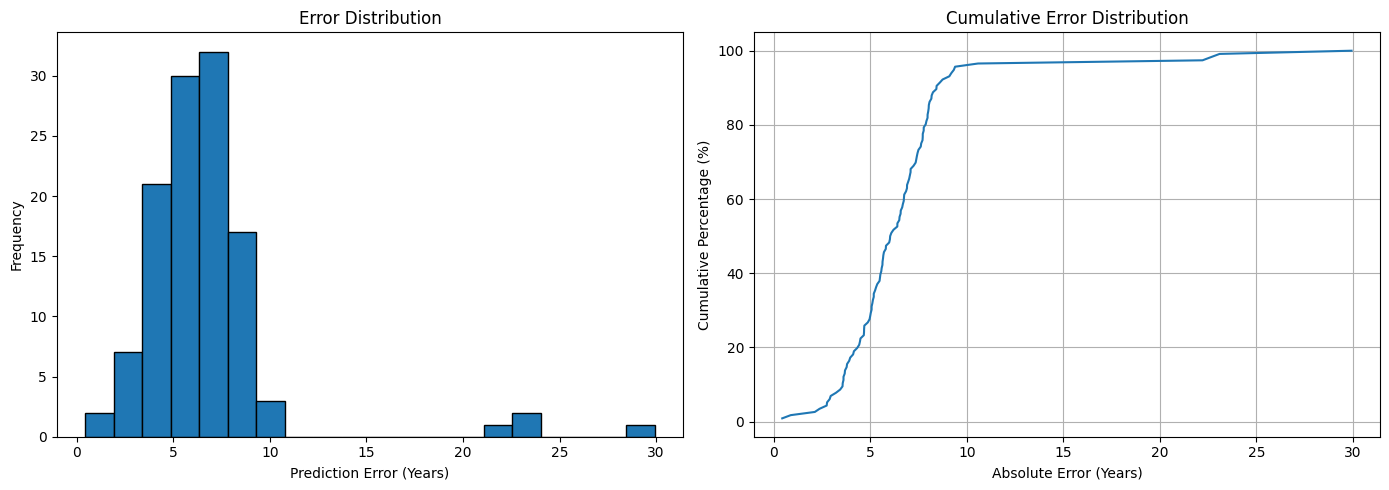

In [23]:
# Group prediction by image
predicted_images, true_images = group_predictions_by_image_id(ensemble_predictions_with_ids, labels_data)

# Compute metrics
evaluation_metrics = compute_evaluation_metrics(true_images, predicted_images)

### Individual Model Metrics


Evaluating ResNet50...
MAE: 7.56
RMSE: 8.43
R2: -0.78
MAPE: 47.73
Within ±2 Years (%): 1.72
Within ±5 Years (%): 10.34
Within ±10 Years (%): 93.97
Max Error: 28.70
Median Error: 6.93
Cumulative Error ≤ 5 Years (%): 10.34


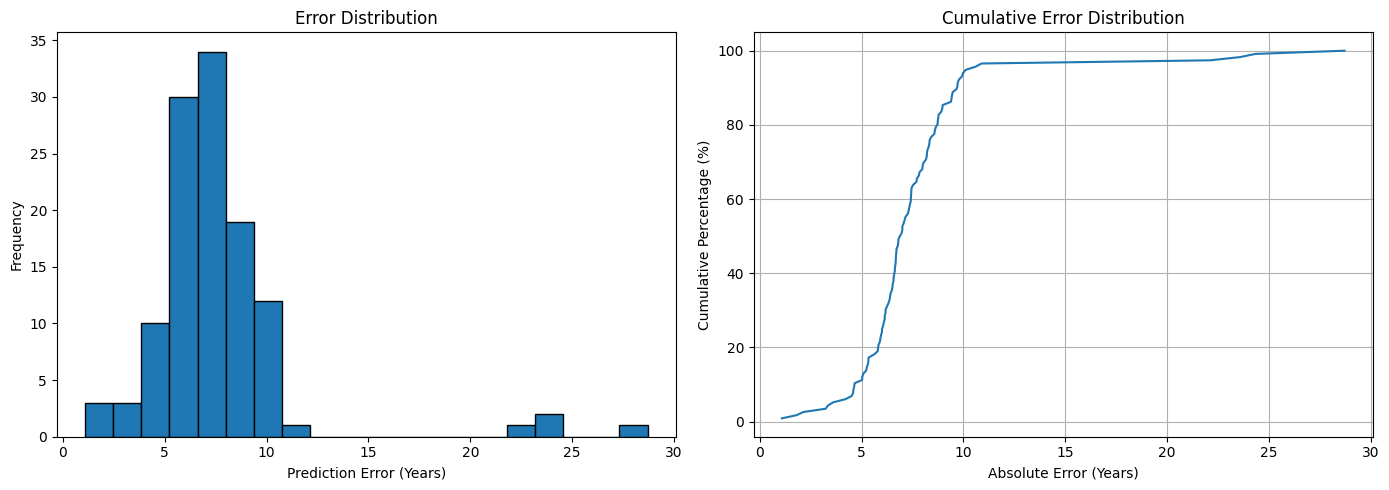





Evaluating InceptionV3...
MAE: 8.59
RMSE: 9.67
R2: -1.34
MAPE: 54.45
Within ±2 Years (%): 2.59
Within ±5 Years (%): 18.97
Within ±10 Years (%): 69.83
Max Error: 29.56
Median Error: 8.03
Cumulative Error ≤ 5 Years (%): 18.97


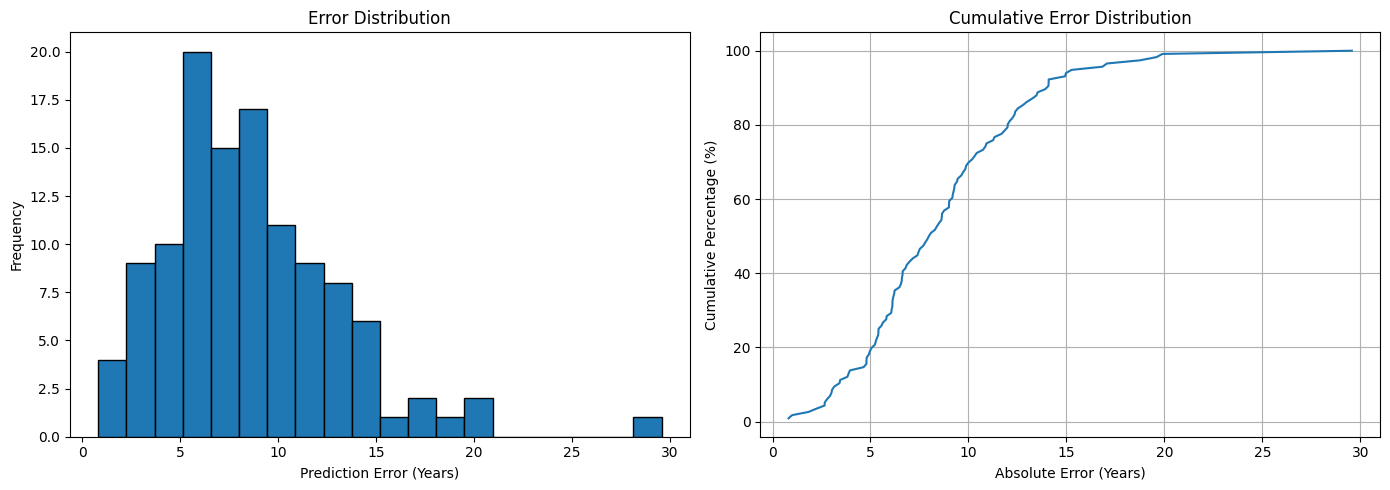





Evaluating InceptionResNetV2...
MAE: 3.79
RMSE: 6.17
R2: 0.05
MAPE: 21.09
Within ±2 Years (%): 38.79
Within ±5 Years (%): 81.03
Within ±10 Years (%): 95.69
Max Error: 32.96
Median Error: 2.52
Cumulative Error ≤ 5 Years (%): 81.03


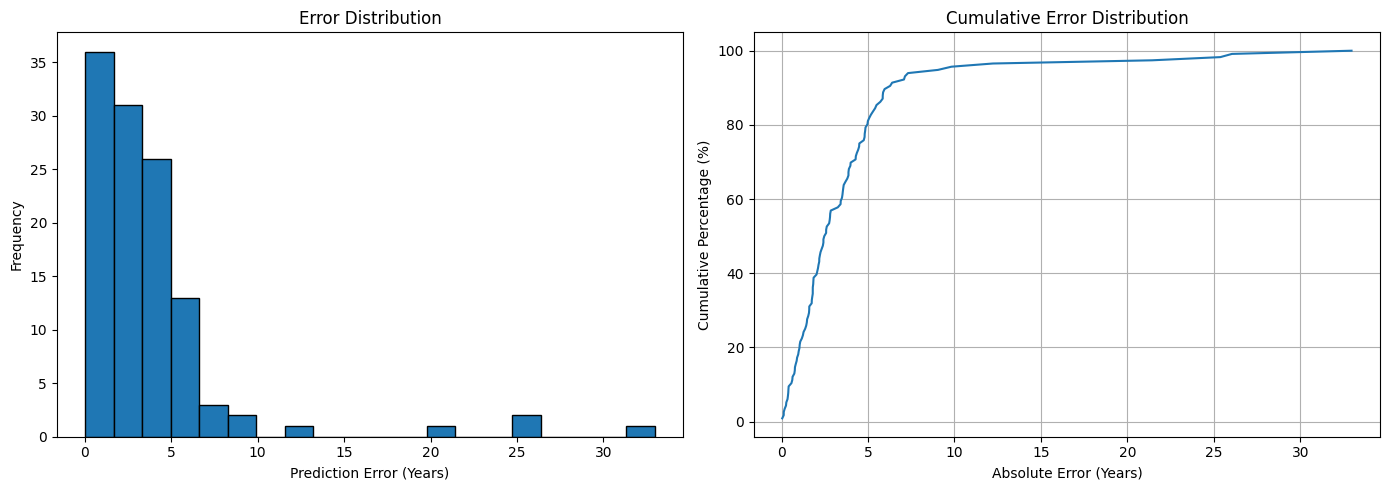





Evaluating DenseNet121...
MAE: 6.19
RMSE: 7.43
R2: -0.38
MAPE: 38.33
Within ±2 Years (%): 7.76
Within ±5 Years (%): 40.52
Within ±10 Years (%): 94.83
Max Error: 28.89
Median Error: 5.53
Cumulative Error ≤ 5 Years (%): 40.52


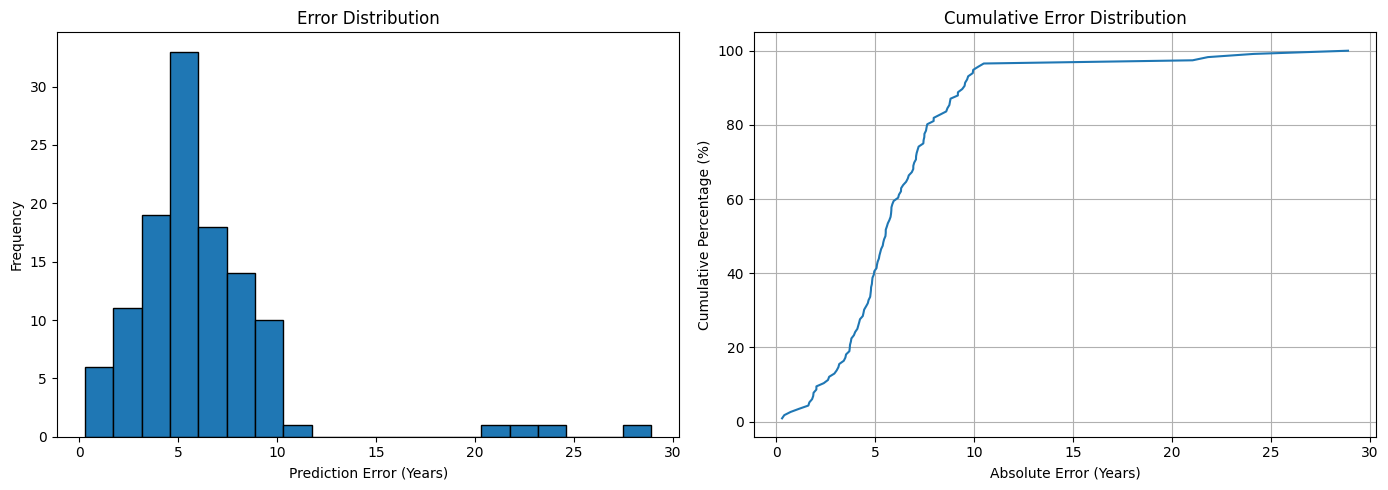





Evaluating EfficientNetV2M...
MAE: 7.26
RMSE: 8.25
R2: -0.70
MAPE: 45.44
Within ±2 Years (%): 1.72
Within ±5 Years (%): 15.52
Within ±10 Years (%): 96.55
Max Error: 29.51
Median Error: 6.61
Cumulative Error ≤ 5 Years (%): 15.52


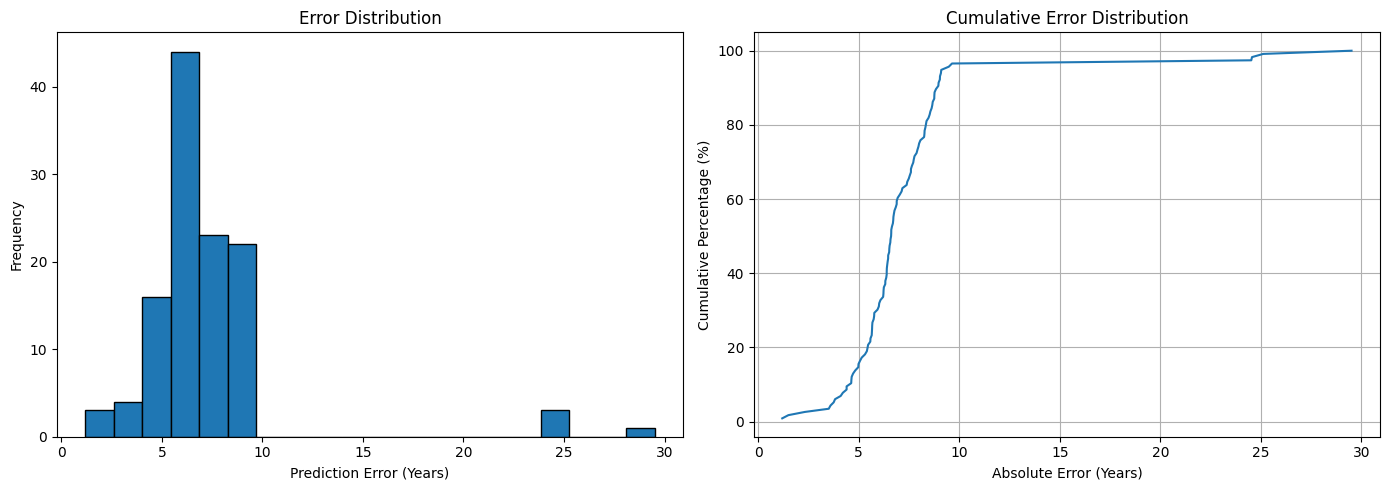

In [24]:
# Build a dictionary to store each model's predictions (after grouping by image ID)
model_predictions_dict = {}
true_ages = None  # Will be set once from the first model’s predictions

for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    predictions_with_ids = []

    # Iterate over the test dataset and gather predictions with image IDs
    for batch in test_dataset:
        patches, _, image_ids = batch
        preds = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(preds, image_ids.numpy()))

    # Group predictions by image ID (returns (predicted_ages, true_ages))
    model_preds, model_true = group_predictions_by_image_id(predictions_with_ids, labels_data)

    # Store this model's predictions in the dictionary
    model_predictions_dict[model_name] = model_preds

    # Set true_ages once (assuming all models cover the same test set)
    if true_ages is None:
        true_ages = model_true

    # Optionally, compute and display individual evaluation metrics
    _ = compute_evaluation_metrics(model_true, model_preds)
    print("\n\n")

### Kappa

In [ ]:
def classify_age(age):
    """
    Classifies a continuous age value into one of four age groups.

    Args:
        age (float): The age value.

    Returns:
        int: Age group number (1 to 4).
            1: Age ≤ 15
            2: 16 ≤ Age ≤ 25
            3: 26 ≤ Age ≤ 50
            4: Age > 50
    """
    if age <= 15:
        return 1
    elif age <= 25:
        return 2
    elif age <= 50:
        return 3
    else:
        return 4

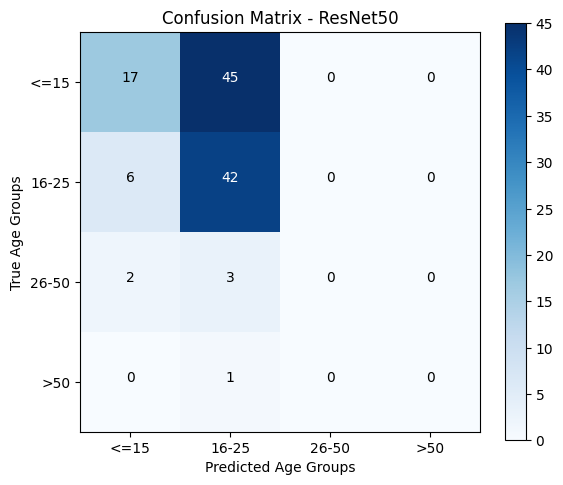

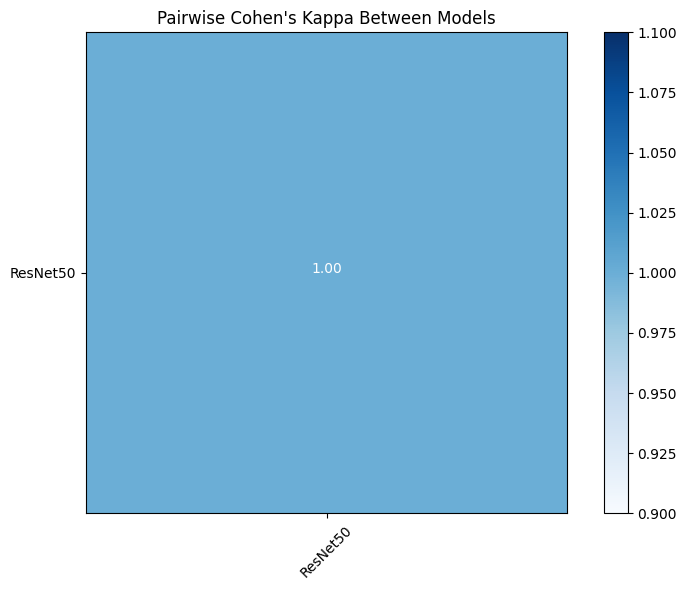

Pairwise Cohen's Kappa Matrix:
[[1.]]
Fleiss' Kappa (multi-model agreement): nan


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/inter_rater.py:258: RuntimeWarning: invalid value encountered in divide
  p_rat = (table2.sum(1) - n_rat) / (n_rat * (n_rat - 1.))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from sklearn.metrics import confusion_matrix, cohen_kappa_score

def analyze_model_agreement(true_ages, model_predictions_dict, plot=True):
    """
    Analyzes agreement between models' age predictions.

    This function:
      1. Converts continuous predictions (and true ages) into categorical age groups
         using your standard `classify_age` function.
      2. Computes a confusion matrix (predicted vs. true categories) for each model.
      3. Computes pairwise Cohen's kappa scores between models to assess how similarly they predict.
      4. Optionally computes Fleiss' kappa for overall multi-model agreement.
      5. Optionally plots:
          - The confusion matrix for each model (with age group labels).
          - A heatmap of pairwise Cohen's kappa scores (with model names).

    Args:
        true_ages (np.ndarray): Array of true continuous ages.
        model_predictions_dict (dict): Dictionary where keys are model names and values are arrays
                                       of predicted continuous ages.
        plot (bool): Whether to generate plots.

    Returns:
        dict: Dictionary containing:
            - 'confusion_matrices': dict mapping each model name to its confusion matrix.
            - 'pairwise_kappa': 2D numpy array of pairwise Cohen's kappa scores.
            - 'model_names': List of model names (order corresponds to pairwise_kappa rows/columns).
            - 'fleiss_kappa': Fleiss' kappa score across all models (if computed, else None).
    """
    # Define the complete set of categorical labels
    labels_categories = [1, 2, 3, 4]

    # Convert true ages into categorical groups using classify_age
    true_categories = np.array([classify_age(age) for age in true_ages])

    # Compute confusion matrices for each model and store each model's categorical predictions.
    confusion_matrices = {}
    model_categories = {}
    for model_name, predictions in model_predictions_dict.items():
        # Convert continuous predictions into age groups using the same binning strategy.
        preds_categories = np.array([classify_age(age) for age in predictions])
        model_categories[model_name] = preds_categories

        # Warn if a model's predictions have only one unique category.
        unique_preds = np.unique(preds_categories)
        if len(unique_preds) == 1:
            print(f"Warning: Model {model_name} produced only one category: {unique_preds}")

        # Suppress warning from confusion_matrix about a single label by using a warnings context.
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="A single label was found in")
            cm = confusion_matrix(true_categories, preds_categories, labels=labels_categories)
        confusion_matrices[model_name] = cm

        if plot:
            # Plot the confusion matrix for the model.
            age_labels = ['<=15', '16-25', '26-50', '>50']
            plt.figure(figsize=(6, 5))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix - {model_name}')
            plt.colorbar()
            tick_marks = np.arange(len(age_labels))
            plt.xticks(tick_marks, age_labels)
            plt.yticks(tick_marks, age_labels)
            thresh = cm.max() / 2.0 if cm.max() > 0 else 1
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            plt.ylabel('True Age Groups')
            plt.xlabel('Predicted Age Groups')
            plt.tight_layout()
            plt.show()

    # Compute pairwise Cohen's kappa scores between models (using their categorical predictions).
    model_names = list(model_predictions_dict.keys())
    n_models = len(model_names)
    pairwise_kappa = np.zeros((n_models, n_models))
    for i in range(n_models):
        for j in range(n_models):
            if i == j:
                pairwise_kappa[i, j] = 1.0
            else:
                preds_i = model_categories[model_names[i]]
                preds_j = model_categories[model_names[j]]
                # If either prediction set has less than 2 unique values, assign 0.
                if len(np.unique(preds_i)) < 2 or len(np.unique(preds_j)) < 2:
                    kappa = 0.0
                else:
                    kappa = cohen_kappa_score(preds_i, preds_j, labels=labels_categories)
                    # If kappa is NaN, substitute with 0.
                    if np.isnan(kappa):
                        kappa = 0.0
                pairwise_kappa[i, j] = kappa

    if plot:
        # Plot heatmap of pairwise Cohen's kappa scores.
        plt.figure(figsize=(8, 6))
        plt.imshow(pairwise_kappa, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Pairwise Cohen's Kappa Between Models")
        plt.colorbar()
        tick_marks = np.arange(n_models)
        plt.xticks(tick_marks, model_names, rotation=45)
        plt.yticks(tick_marks, model_names)
        for i in range(n_models):
            for j in range(n_models):
                plt.text(j, i, f"{pairwise_kappa[i, j]:.2f}",
                         horizontalalignment="center",
                         color="white" if pairwise_kappa[i, j] > 0.5 else "black")
        plt.tight_layout()
        plt.show()

    # Compute Fleiss' Kappa for multi-model agreement (optional)
    # Prepare a ratings matrix: each row corresponds to a test instance,
    # and each column counts how many models predicted each age group.
    n_samples = len(true_categories)
    n_categories = len(labels_categories)
    ratings = np.zeros((n_samples, n_categories), dtype=int)
    for i in range(n_samples):
        for model_name in model_names:
            rating = model_categories[model_name][i]
            # Adjust index: category 1 -> index 0, etc.
            ratings[i, rating - 1] += 1
    try:
        from statsmodels.stats.inter_rater import fleiss_kappa
        fleiss = fleiss_kappa(ratings, method='fleiss')
    except ImportError:
        print("statsmodels is required for Fleiss' kappa. Skipping this metric.")
        fleiss = None

    results = {
        "confusion_matrices": confusion_matrices,
        "pairwise_kappa": pairwise_kappa,
        "model_names": model_names,
        "fleiss_kappa": fleiss
    }

    return results


# Now that all models have been evaluated, analyze the inter-model agreement
results = analyze_model_agreement(true_ages, model_predictions_dict, plot=True)

# Example output:
print("Pairwise Cohen's Kappa Matrix:")
print(results['pairwise_kappa'])
if results['fleiss_kappa'] is not None:
    print("Fleiss' Kappa (multi-model agreement):", results['fleiss_kappa'])

### Save patch level predictions to csv

In [ ]:
import csv
import os

# Path to save the patch-level predictions CSV.
csv_save_path = '/content/drive/MyDrive/HHD_AgeSplit/ensemble_training_augmentation/patch_level_predictions.csv'

# Open the CSV file for writing.
with open(csv_save_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    # Write header: model name, image ID, patch index, prediction.
    writer.writerow(['Model', 'ImageID', 'PatchIndex', 'Prediction'])

    # Iterate over each trained model.
    for model_name, model in trained_models.items():
        print(f"Processing predictions for {model_name}...")
        patch_index = 0  # Running index for patches
        # Iterate over batches in the test dataset.
        for batch in test_dataset:
            patches, _, image_ids = batch
            # Compute predictions for the current batch.
            preds = model.predict(patches, verbose=0).flatten()
            # Write each patch's prediction to the CSV.
            for i in range(len(preds)):
                # Decode image ID from bytes to string.
                writer.writerow([
                    model_name,
                    image_ids.numpy()[i].decode('utf-8'),
                    patch_index + i,
                    preds[i]
                ])
            patch_index += len(preds)

print(f"Patch-level predictions saved to {os.path.abspath(csv_save_path)}")

Processing predictions for ResNet50...
Processing predictions for InceptionV3...
Processing predictions for InceptionResNetV2...
Processing predictions for DenseNet121...
Processing predictions for EfficientNetV2M...
Patch-level predictions saved to /content/drive/MyDrive/HHD_AgeSplit/ensemble_training_augmentation/patch_level_predictions.csv


### Read CSV and Generate Ensemble Predictions Using Weights

MAE: 3.01
RMSE: 5.81
R2: 0.16
MAPE: 16.88
Within ±2 Years (%): 67.24
Within ±5 Years (%): 81.03
Within ±10 Years (%): 96.55
Max Error: 28.59
Median Error: 1.31
Cumulative Error ≤ 5 Years (%): 81.03


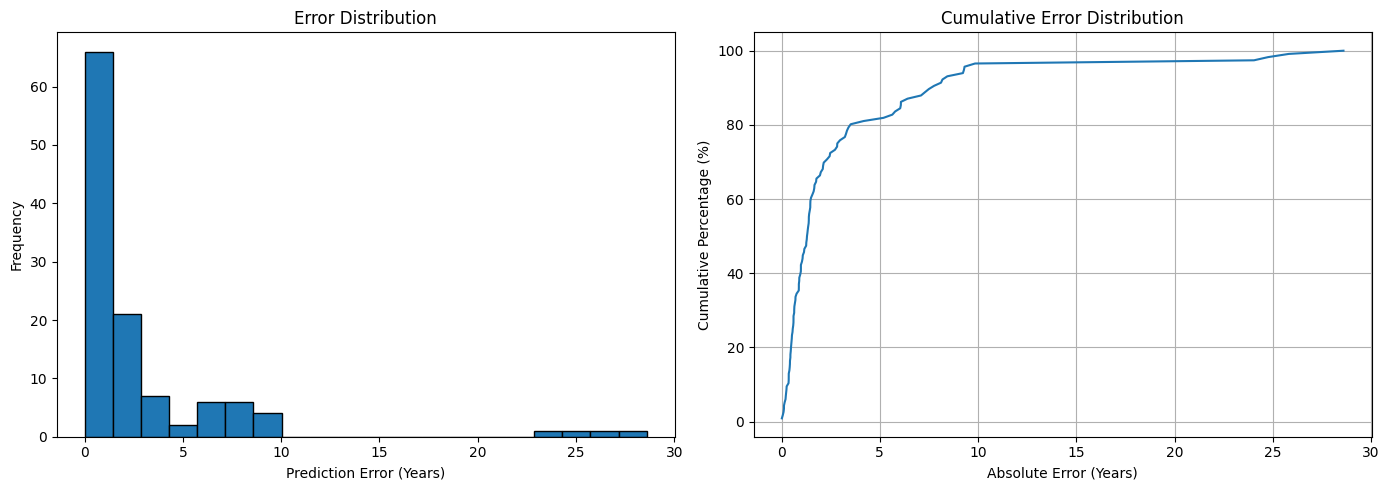

Ensemble predictions computed and saved to: /content/ensemble_predictions.csv


In [ ]:
# Define the ensemble weights for your models.
# Adjust these weights as desired.
weights = {
 'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.2, 'DenseNet121': 0.5, 'EfficientNetV2M': 0.1
}

# Read the CSV file containing patch-level predictions.
df = pd.read_csv(csv_save_path)

# Average patch predictions per model for each image.
avg_df = df.groupby(['Model', 'ImageID'])['Prediction'].mean().reset_index()

# Pivot the table so that each row corresponds to an image and each column to a model.
pivot_df = avg_df.pivot(index='ImageID', columns='Model', values='Prediction').reset_index()

# Function to compute the weighted ensemble prediction for a single image.
def weighted_ensemble(row, weights):
    ensemble_pred = 0.0
    total_weight = 0.0
    for model_name, weight in weights.items():
        if model_name in row and pd.notna(row[model_name]):
            ensemble_pred += row[model_name] * weight
            total_weight += weight
    return ensemble_pred / total_weight if total_weight > 0 else None

# Apply the weighted ensemble calculation for each image.
pivot_df['Ensemble_Prediction'] = pivot_df.apply(lambda row: weighted_ensemble(row, weights), axis=1)

# Now, re-use your evaluation functions:
# Prepare a list of tuples (prediction, image_id) for the ensemble.
predictions_with_ids = list(zip(pivot_df['Ensemble_Prediction'], pivot_df['ImageID'].astype(str).tolist()))

# Group predictions by image using your provided function.
ensemble_preds, true_values = group_predictions_by_image_id(predictions_with_ids, labels_data)

# Compute and display evaluation metrics using your existing function.
metrics = compute_evaluation_metrics(true_values, ensemble_preds)

# Optionally, save the ensemble predictions to a new CSV.
ensemble_csv_path = 'ensemble_predictions.csv'
pivot_df.to_csv(ensemble_csv_path, index=False)
print("Ensemble predictions computed and saved to:", os.path.abspath(ensemble_csv_path))

MAE: 3.23
RMSE: 6.03
R2: 0.09
MAPE: 18.13
Within ±2 Years (%): 56.90
Within ±5 Years (%): 81.90
Within ±10 Years (%): 96.55
Max Error: 30.60
Median Error: 1.59
Cumulative Error ≤ 5 Years (%): 81.90


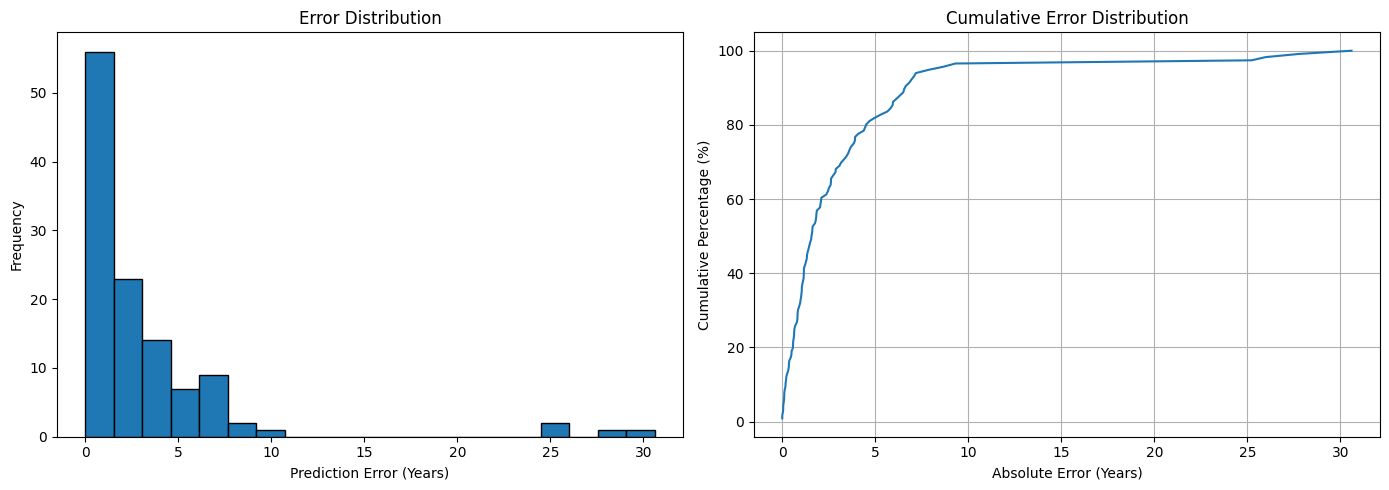

ResNet50 MAE: 3.23
MAE: 5.06
RMSE: 6.55
R2: -0.07
MAPE: 31.30
Within ±2 Years (%): 6.90
Within ±5 Years (%): 67.24
Within ±10 Years (%): 93.97
Max Error: 27.78
Median Error: 4.12
Cumulative Error ≤ 5 Years (%): 67.24


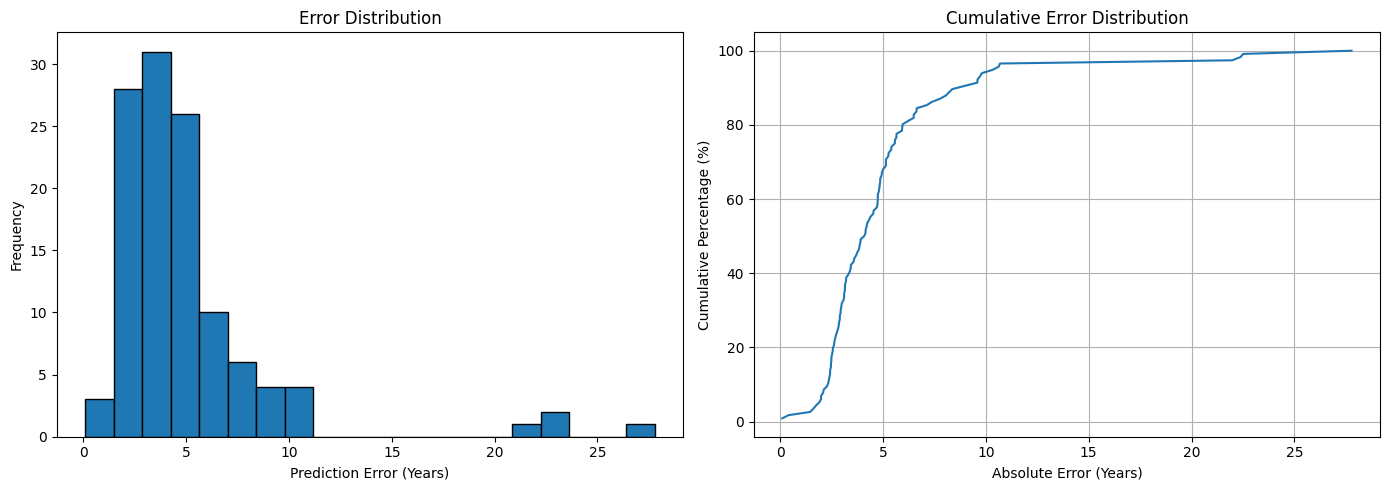

InceptionV3 MAE: 5.06
MAE: 3.64
RMSE: 6.39
R2: -0.02
MAPE: 20.12
Within ±2 Years (%): 43.97
Within ±5 Years (%): 87.07
Within ±10 Years (%): 96.55
Max Error: 32.62
Median Error: 2.46
Cumulative Error ≤ 5 Years (%): 87.07


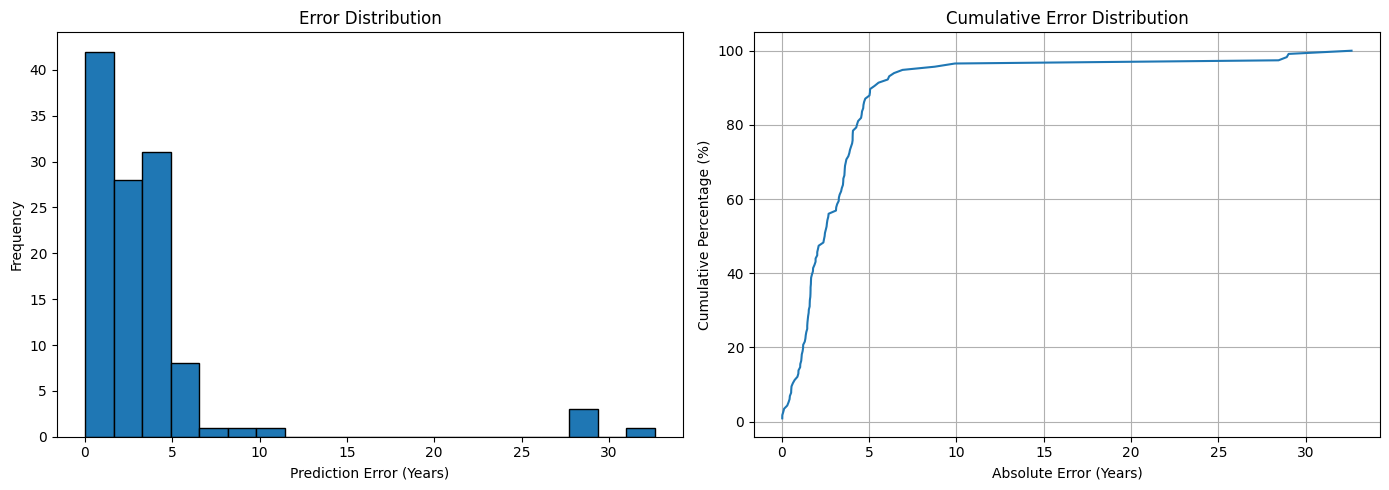

InceptionResNetV2 MAE: 3.64
MAE: 3.97
RMSE: 6.10
R2: 0.07
MAPE: 22.80
Within ±2 Years (%): 33.62
Within ±5 Years (%): 82.76
Within ±10 Years (%): 93.10
Max Error: 26.85
Median Error: 2.76
Cumulative Error ≤ 5 Years (%): 82.76


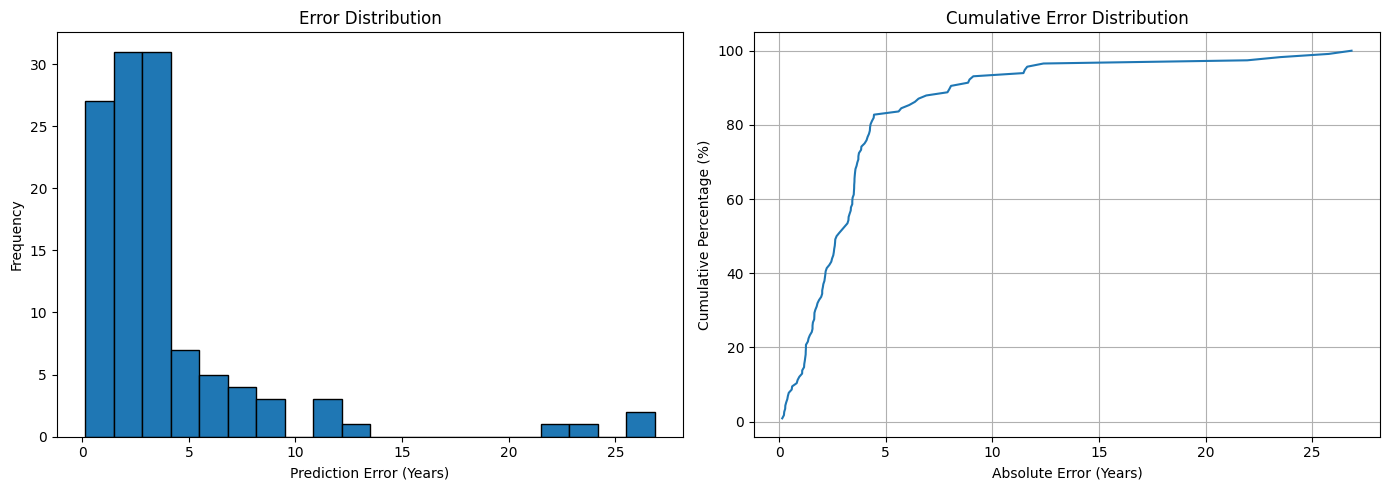

DenseNet121 MAE: 3.97
MAE: 7.17
RMSE: 8.12
R2: -0.65
MAPE: 45.19
Within ±2 Years (%): 0.86
Within ±5 Years (%): 16.38
Within ±10 Years (%): 93.10
Max Error: 28.06
Median Error: 6.39
Cumulative Error ≤ 5 Years (%): 16.38


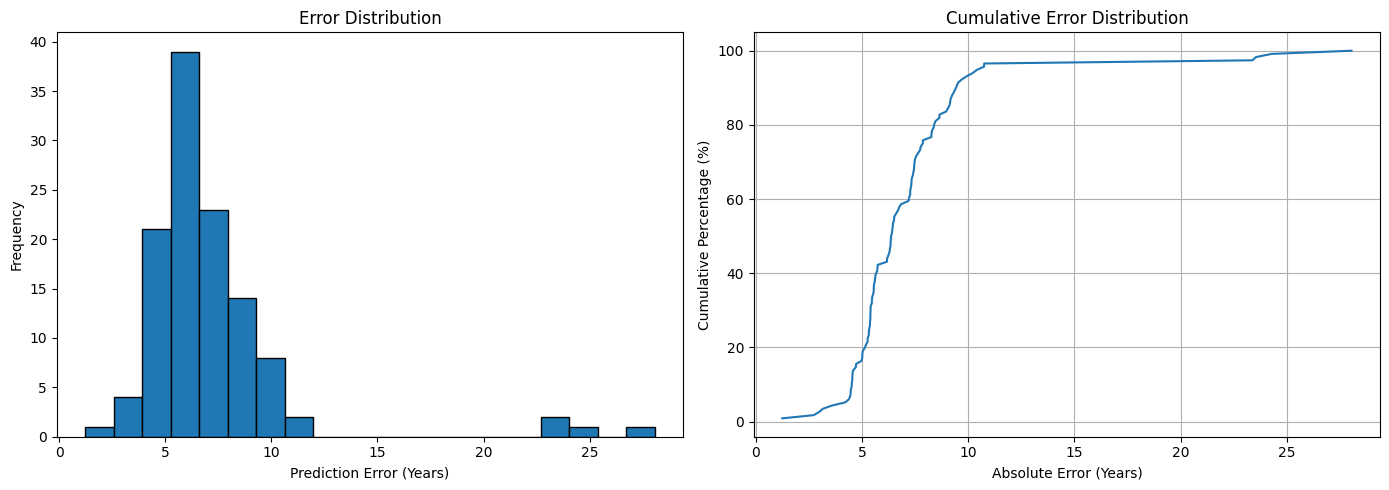

EfficientNetV2M MAE: 7.17
Computed MAE-based ensemble weights (reversed order):
ResNet50: 0.2150
InceptionV3: 0.1951
InceptionResNetV2: 0.2105
DenseNet121: 0.2070
EfficientNetV2M: 0.1723


In [ ]:
from sklearn.metrics import mean_absolute_error

# Compute individual model MAEs for ensemble weight calculation.
model_maes = {}
for model_name, model in trained_models.items():
    predictions_with_ids = []
    # Iterate over the test dataset to gather predictions for this model.
    for batch in test_dataset:
        patches, _, image_ids = batch
        preds = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(preds, image_ids.numpy()))

    # Group predictions by image ID and get true values.
    pred_images, true_images = group_predictions_by_image_id(predictions_with_ids, labels_data)

    # Use your evaluation function to compute metrics.
    metrics = compute_evaluation_metrics(true_images, pred_images)
    model_maes[model_name] = metrics['MAE']
    print(f"{model_name} MAE: {metrics['MAE']:.2f}")

# Compute ensemble weights using the formula:
# weight_i = (total_mae - MAE_i) / ((n_models - 1) * total_mae)
total_mae = sum(model_maes.values())
n_models = len(model_maes)
weights_mae = {model: (total_mae - mae) / ((n_models - 1) * total_mae) for model, mae in model_maes.items()}

print("Computed MAE-based ensemble weights (reversed order):")
for model, weight in weights_mae.items():
    print(f"{model}: {weight:.4f}")

In [ ]:
def grid_search_weights(trained_models, test_dataset, labels_df, search_space, start_index=0):
    """
    Performs a grid search over weight combinations for the given search_space dictionary.
    The search_space should be a dictionary mapping model names to a tuple (min, max, step).
    Only combinations that sum (approximately) to 1 are considered.

    Args:
        trained_models (dict): Dictionary of models to evaluate.
        test_dataset (tf.data.Dataset): Test dataset.
        labels_df (pd.DataFrame): DataFrame containing true labels.
        search_space (dict): Mapping of model name -> (min, max, step)
        start_index (int): Index to start from (if resuming a search).

    Returns:
        tuple: (best_weights, best_mae)
    """
    import itertools
    from sklearn.metrics import mean_absolute_error

    model_names = list(search_space.keys())
    n_models = len(model_names)

    # Generate weight values for each model from its search space.
    weight_values = {}
    for model_name, (min_val, max_val, step) in search_space.items():
        weight_values[model_name] = np.arange(min_val, max_val + step/2, step)  # ensures max is included

    valid_combinations = []
    # Enumerate all combinations for models in the search space.
    for combo in itertools.product(*(weight_values[m] for m in model_names)):
        if np.isclose(sum(combo), 1.0, atol=1e-6):
            valid_combinations.append(dict(zip(model_names, combo)))

    print(f"Total valid combinations: {len(valid_combinations)}")

    best_mae = float('inf')
    best_weights = None

    # Evaluate each valid combination.
    for idx, weights in enumerate(valid_combinations[start_index:], start=start_index):
        print(f"Testing combination {idx+1}/{len(valid_combinations)}: {weights}")
        ensemble_preds_with_ids = ensemble_predict_with_weights(trained_models, test_dataset, weights)
        pred_images, true_images = group_predictions_by_image_id(ensemble_preds_with_ids, labels_df)
        mae = mean_absolute_error(true_images, pred_images)
        print("MAE:", mae)
        if mae < best_mae:
            best_mae = mae
            best_weights = weights.copy()
            print("New best weights found:", best_weights, "with MAE:", best_mae)

    print("Best weights found:", best_weights, "with MAE:", best_mae)
    return best_weights, best_mae


In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import mean_absolute_error

# ----------------------------
# Step 1: Load CSV Predictions
# ----------------------------
# Assumes you have already saved the patch-level predictions CSV (csv_save_path)
# and then aggregated them to produce a pivot table with one row per image.
# The pivot table should have one column per model (e.g. 'ResNet50', 'InceptionV3', etc.)
# and a column 'ImageID' that uniquely identifies each image.
csv_save_path = 'patch_level_predictions.csv'
df = pd.read_csv(csv_save_path)

# Average patch predictions per model for each image.
avg_df = df.groupby(['Model', 'ImageID'])['Prediction'].mean().reset_index()

# Pivot the table so that each row corresponds to an image and each column to a model.
pivot_df = avg_df.pivot(index='ImageID', columns='Model', values='Prediction').reset_index()

# ----------------------------
# Step 2: Prepare True Labels
# ----------------------------
# Create a dictionary mapping ImageID to the true age.
true_age_dict = dict(zip(labels_data['File'], labels_data['Age']))

# ----------------------------
# Step 3: Define the CSV-based Grid Search Function
# ----------------------------
def weighted_ensemble_from_row(row, weights, group_models):
    """Compute the weighted ensemble prediction for a single row from pivot_df."""
    ensemble_pred = 0.0
    total_weight = 0.0
    for model in group_models:
        # Use only if the column exists and the value is not NaN.
        if model in row and pd.notna(row[model]):
            ensemble_pred += row[model] * weights[model]
            total_weight += weights[model]
    return ensemble_pred / total_weight if total_weight > 0 else np.nan

def grid_search_weights_from_csv(pivot_df, true_age_dict, search_space, group_models, start_index=0):
    """
    Perform a grid search over weight combinations for the given group_models using the pivot_df predictions.
    Only combinations that sum (approximately) to 1 are considered.

    Args:
        pivot_df (pd.DataFrame): DataFrame with columns 'ImageID' and one column per model.
        true_age_dict (dict): Dictionary mapping ImageID to the true age.
        search_space (dict): Dictionary mapping model name -> (min, max, step)
        group_models (list): List of model names for this ensemble group.
        start_index (int): Index to start from if resuming search.

    Returns:
        tuple: (best_weights, best_mae)
    """
    # Generate possible weight values for each model in group_models.
    weight_values = {}
    for model in group_models:
        min_val, max_val, step = search_space[model]
        weight_values[model] = np.arange(min_val, max_val + step/2, step)  # ensures max is included

    valid_combinations = []
    for combo in itertools.product(*(weight_values[m] for m in group_models)):
        if np.isclose(sum(combo), 1.0, atol=1e-6):
            valid_combinations.append(dict(zip(group_models, combo)))

    print(f"Total valid combinations for group {group_models}: {len(valid_combinations)}")

    best_mae = float('inf')
    best_weights = None

    # Evaluate each valid combination.
    for idx, weights in enumerate(valid_combinations[start_index:], start=start_index):
        # Compute ensemble predictions for each image using the given weight combination.
        df_temp = pivot_df.copy()
        df_temp['Ensemble_Prediction'] = df_temp.apply(lambda row: weighted_ensemble_from_row(row, weights, group_models), axis=1)
        # Drop rows with NaN predictions.
        df_temp = df_temp.dropna(subset=['Ensemble_Prediction'])

        y_true = []
        y_pred = []
        for _, row in df_temp.iterrows():
            image_id = row['ImageID']
            if image_id in true_age_dict:
                y_true.append(true_age_dict[image_id])
                y_pred.append(row['Ensemble_Prediction'])
        mae = mean_absolute_error(y_true, y_pred) if y_true and y_pred else np.inf
        print(f"Combination {idx+1}/{len(valid_combinations)}: {weights} => MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_weights = weights.copy()
            print("New best found:", best_weights, "with MAE:", best_mae)

    print("Best weights found for group", group_models, ":", best_weights, "with MAE:", best_mae)
    return best_weights, best_mae

# ----------------------------
# Step 4: Define Ensemble Groups & Search Space
# ----------------------------
# Provided MAEs for each model.
model_mae = {
    'ResNet50': 3.23,
    'InceptionV3': 5.06,
    'InceptionResNetV2': 3.64,
    'DenseNet121': 3.97,
    'EfficientNetV2M': 7.17
}

# Define ensemble groups (based on lower MAE is better).
ensemble_groups = {
    'Full Ensemble': ['ResNet50', 'InceptionV3', 'InceptionResNetV2', 'DenseNet121', 'EfficientNetV2M'],
    'Best 4': ['ResNet50', 'InceptionResNetV2', 'DenseNet121', 'InceptionV3'],  # drop EfficientNetV2M
    'Best 3': ['ResNet50', 'InceptionResNetV2', 'DenseNet121'],                # drop InceptionV3 & EfficientNetV2M
    'Best 2': ['ResNet50', 'InceptionResNetV2']                                  # top 2 models
}

# Define the search space for grid search:
# For each model, set weights to vary from 0.1 to 0.9 in steps of 0.1.
grid_search_step = 0.1
grid_search_min = 0.1
grid_search_max = 0.9
generic_search_space = {model: (grid_search_min, grid_search_max, grid_search_step)
                        for model in model_mae.keys()}

# ----------------------------
# Step 5: Run Grid Search for Each Ensemble Group Using CSV Predictions
# ----------------------------
final_summary = []  # To store final results.

print("\n=== Grid Search for Ensemble Weights (Using CSV Predictions) ===")
for group_name, group_models in ensemble_groups.items():
    print(f"\n--- Ensemble Group: {group_name} (Models: {group_models}) ---")
    # Restrict search space to models in the ensemble group.
    search_space = {model: generic_search_space[model] for model in group_models}

    # Method 2.2: Grid Search Weights
    best_grid_weights, best_grid_mae = grid_search_weights_from_csv(pivot_df.copy(), true_age_dict, search_space, group_models)

    # Method 2.1: MAE-based weights using the provided formula:
    # weight_i = (total MAE - MAE_i) / ((n-1) * total MAE)
    total = sum(model_mae[m] for m in group_models)
    n = len(group_models)
    mae_based_weights = {m: (total - model_mae[m]) / ((n - 1) * total) for m in group_models}

    # Compute ensemble predictions and MAE for the MAE-based weights.
    df_temp = pivot_df.copy()
    df_temp['Ensemble_Prediction'] = df_temp.apply(lambda row: weighted_ensemble_from_row(row, mae_based_weights, group_models), axis=1)
    df_temp = df_temp.dropna(subset=['Ensemble_Prediction'])
    y_true, y_pred = [], []
    for _, row in df_temp.iterrows():
        image_id = row['ImageID']
        if image_id in true_age_dict:
            y_true.append(true_age_dict[image_id])
            y_pred.append(row['Ensemble_Prediction'])
    mae_based_ensemble_mae = mean_absolute_error(y_true, y_pred) if y_true and y_pred else np.inf

    # Save results in summary.
    final_summary.append({
        "Group": group_name,
        "Grid Search Weights": best_grid_weights,
        "Grid Search MAE": best_grid_mae,
        "MAE-based Weights": mae_based_weights,
        "MAE-based Ensemble MAE": mae_based_ensemble_mae
    })

    # Print detailed results for this ensemble group.
    print("\nGrid Search Best Weights:")
    for model, weight in best_grid_weights.items():
        print(f"  {model}: {weight:.4f}")
    print(f"Ensemble MAE from Grid Search: {best_grid_mae:.4f}")
    print("\nMAE-based Weights:")
    for model, weight in mae_based_weights.items():
        print(f"  {model}: {weight:.4f}")
    print(f"Ensemble MAE from MAE-based Weights: {mae_based_ensemble_mae:.4f}")

# ----------------------------
# Final Summary Output
# ----------------------------
print("\n=== Final Summary of Ensemble Groups ===")
for summary in final_summary:
    print(f"\nEnsemble Group: {summary['Group']}")
    print("  Grid Search Weights:       ", summary["Grid Search Weights"])
    print("  Grid Search Ensemble MAE:  ", summary["Grid Search MAE"])
    print("  MAE-based Weights:         ", summary["MAE-based Weights"])
    print("  MAE-based Ensemble MAE:    ", summary["MAE-based Ensemble MAE"])



=== Grid Search for Ensemble Weights (Using CSV Predictions) ===

--- Ensemble Group: Full Ensemble (Models: ['ResNet50', 'InceptionV3', 'InceptionResNetV2', 'DenseNet121', 'EfficientNetV2M']) ---
Total valid combinations for group ['ResNet50', 'InceptionV3', 'InceptionResNetV2', 'DenseNet121', 'EfficientNetV2M']: 126
Combination 1/126: {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.1, 'DenseNet121': 0.1, 'EfficientNetV2M': 0.6} => MAE: 5.5252
New best found: {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.1, 'DenseNet121': 0.1, 'EfficientNetV2M': 0.6} with MAE: 5.525235158643947
Combination 2/126: {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.1, 'DenseNet121': 0.2, 'EfficientNetV2M': 0.5} => MAE: 4.8717
New best found: {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.1, 'DenseNet121': 0.2, 'EfficientNetV2M': 0.5} with MAE: 4.871713614612656
Combination 3/126: {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.1, 'DenseNe

MAE: 3.01
RMSE: 5.81
R2: 0.16
MAPE: 16.88
Within ±2 Years (%): 67.24
Within ±5 Years (%): 81.03
Within ±10 Years (%): 96.55
Max Error: 28.59
Median Error: 1.31
Cumulative Error ≤ 5 Years (%): 81.03


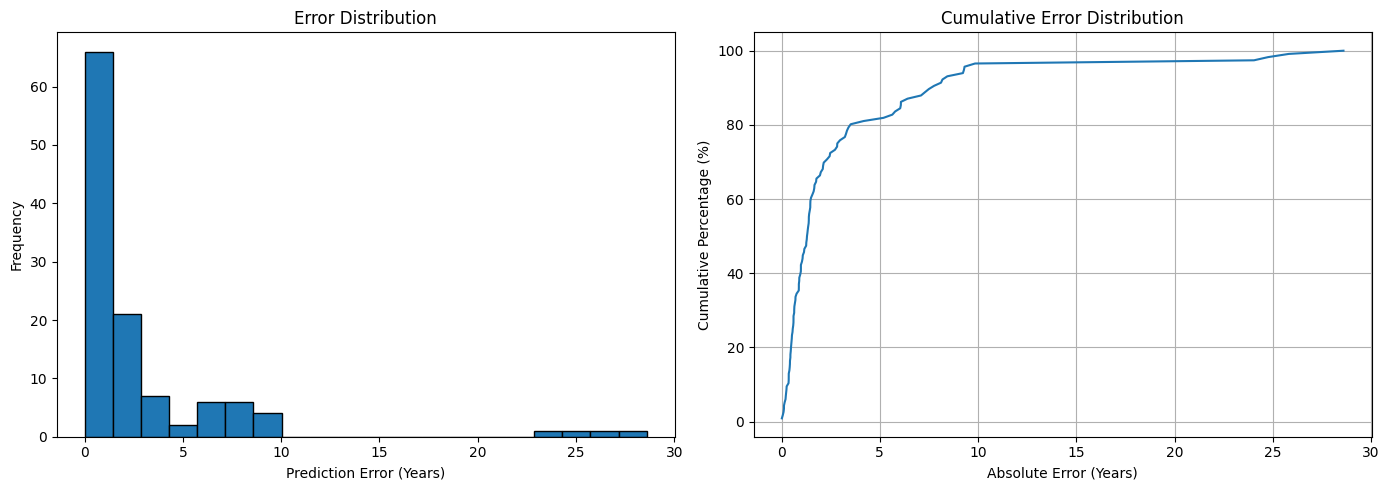

MAE: 3.75
RMSE: 6.08
R2: 0.08
MAPE: 21.97
Within ±2 Years (%): 41.38
Within ±5 Years (%): 80.17
Within ±10 Years (%): 96.55
Max Error: 29.26
Median Error: 2.30
Cumulative Error ≤ 5 Years (%): 80.17


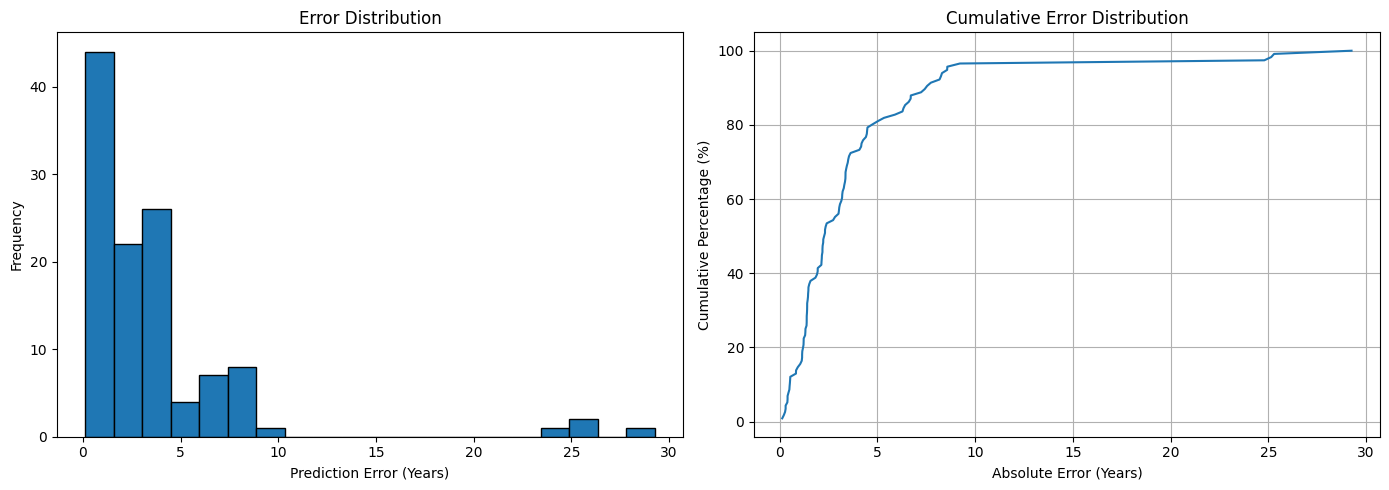

MAE: 2.90
RMSE: 5.83
R2: 0.15
MAPE: 15.85
Within ±2 Years (%): 68.10
Within ±5 Years (%): 81.90
Within ±10 Years (%): 96.55
Max Error: 29.62
Median Error: 1.19
Cumulative Error ≤ 5 Years (%): 81.90


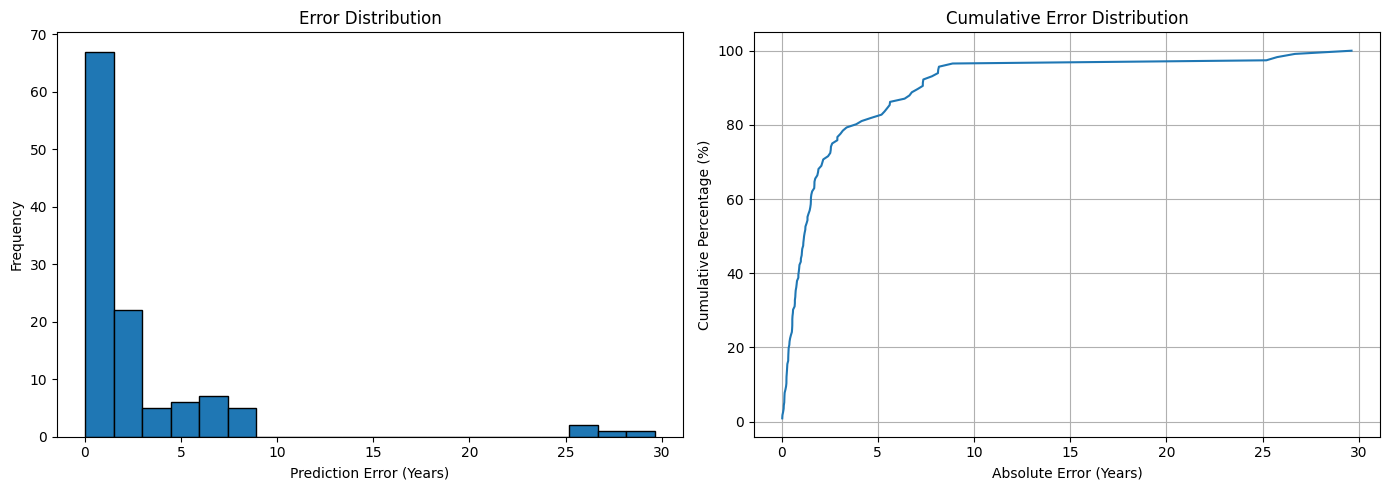

MAE: 3.14
RMSE: 5.88
R2: 0.14
MAPE: 17.71
Within ±2 Years (%): 55.17
Within ±5 Years (%): 81.03
Within ±10 Years (%): 96.55
Max Error: 29.54
Median Error: 1.36
Cumulative Error ≤ 5 Years (%): 81.03


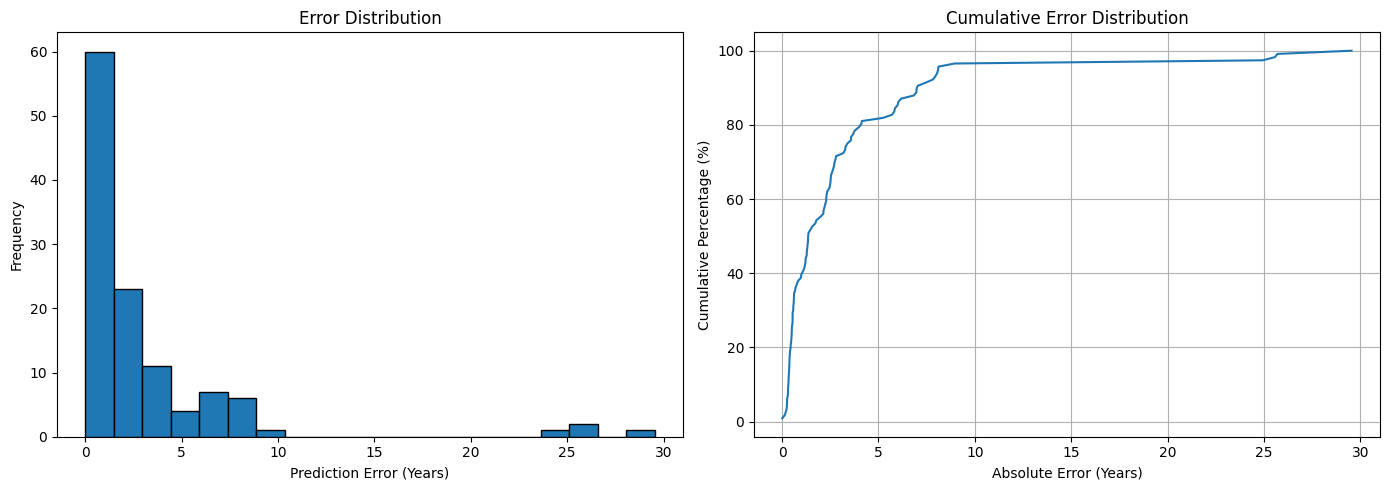

MAE: 2.85
RMSE: 5.87
R2: 0.14
MAPE: 15.30
Within ±2 Years (%): 68.97
Within ±5 Years (%): 84.48
Within ±10 Years (%): 96.55
Max Error: 30.11
Median Error: 1.26
Cumulative Error ≤ 5 Years (%): 84.48


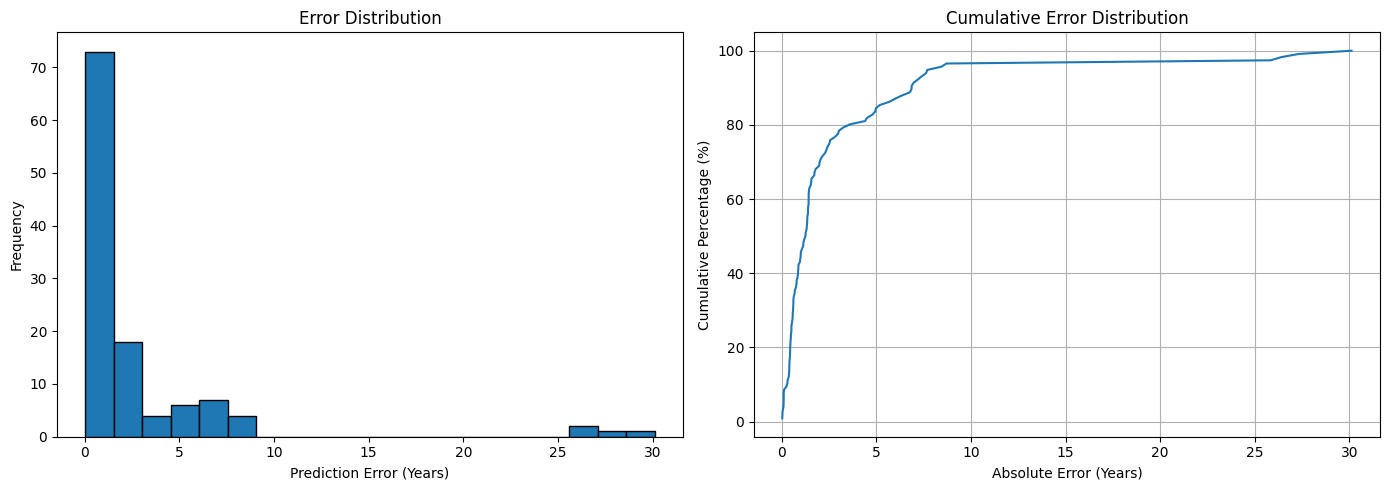

MAE: 2.86
RMSE: 5.86
R2: 0.14
MAPE: 15.48
Within ±2 Years (%): 68.10
Within ±5 Years (%): 82.76
Within ±10 Years (%): 96.55
Max Error: 30.08
Median Error: 1.21
Cumulative Error ≤ 5 Years (%): 82.76


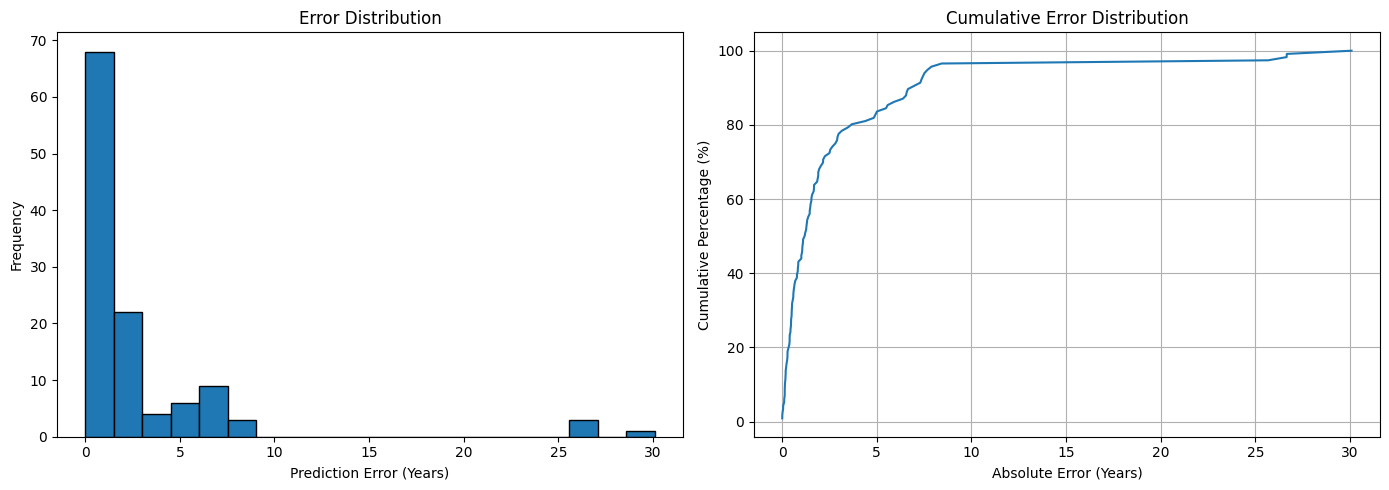

MAE: 3.24
RMSE: 6.04
R2: 0.09
MAPE: 18.17
Within ±2 Years (%): 56.90
Within ±5 Years (%): 81.90
Within ±10 Years (%): 96.55
Max Error: 30.80
Median Error: 1.58
Cumulative Error ≤ 5 Years (%): 81.90


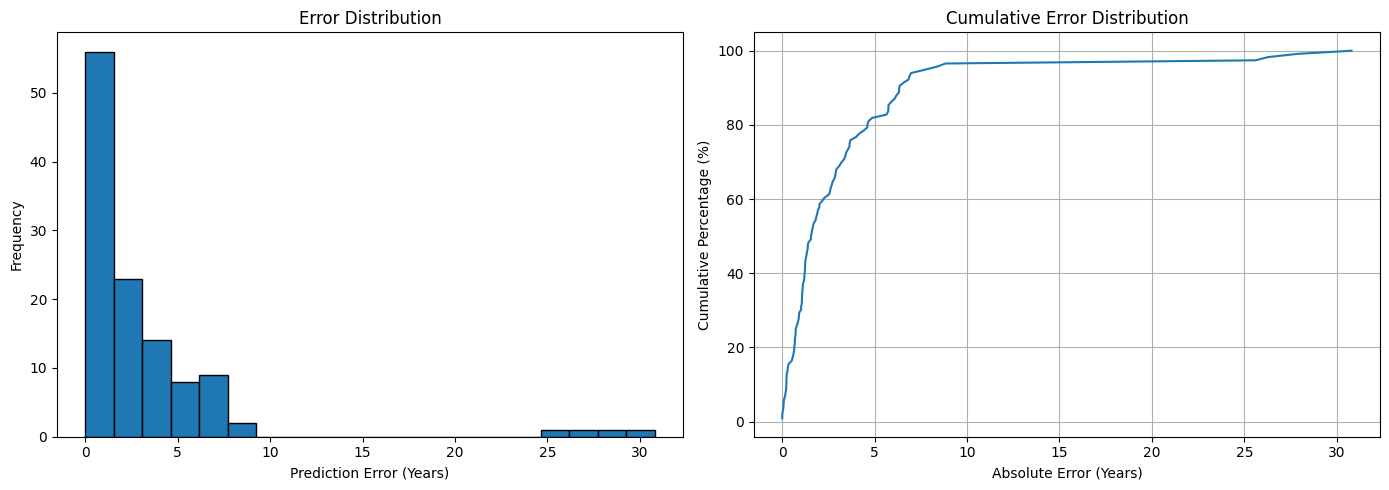

MAE: 3.35
RMSE: 6.14
R2: 0.06
MAPE: 18.61
Within ±2 Years (%): 53.45
Within ±5 Years (%): 82.76
Within ±10 Years (%): 96.55
Max Error: 31.55
Median Error: 1.69
Cumulative Error ≤ 5 Years (%): 82.76


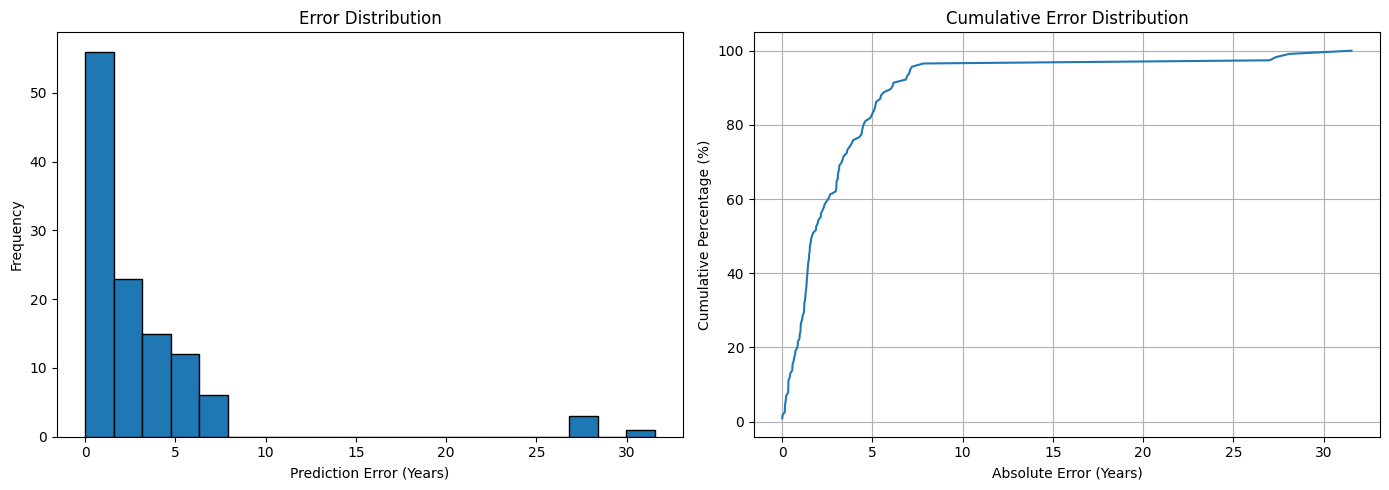

  Ensemble Group       Method  \
0  Full Ensemble  Grid Search   
1  Full Ensemble    MAE-based   
2         Best 4  Grid Search   
3         Best 4    MAE-based   
4         Best 3  Grid Search   
5         Best 3    MAE-based   
6         Best 2  Grid Search   
7         Best 2    MAE-based   

                                             Weights       MAE      RMSE  \
0  {'ResNet50': 0.1, 'InceptionV3': 0.1, 'Incepti...  3.012343  5.807076   
1  {'ResNet50': 0.21499783268313827, 'InceptionV3...  3.745948  6.080814   
2  {'ResNet50': 0.1, 'InceptionResNetV2': 0.4, 'D...  2.899833  5.829393   
3  {'ResNet50': 0.26561844863731654, 'InceptionRe...  3.135316  5.876394   
4  {'ResNet50': 0.1, 'InceptionResNetV2': 0.5, 'D...  2.850656  5.867193   
5  {'ResNet50': 0.35101476014760147, 'InceptionRe...  2.857604  5.862443   
6        {'ResNet50': 0.9, 'InceptionResNetV2': 0.1}  3.243483  6.038997   
7  {'ResNet50': 0.529839883551674, 'InceptionResN...  3.349336  6.135807   

         R2   MAP

In [ ]:
import numpy as np
import pandas as pd

# ----------------------------
# Assume these helper objects/functions are already defined:
# - pivot_df: DataFrame with one row per image, columns: 'ImageID' and each model's prediction.
# - true_age_dict: Dictionary mapping ImageID (from labels_data['File']) to true age.
# - ensemble_groups: Dictionary mapping group name -> list of model names (e.g. Full Ensemble, Best 4, etc.).
# - weighted_ensemble_from_row(row, weights, group_models): returns weighted prediction for that row.
# - compute_evaluation_metrics(true_images, predicted_images): returns a dict with keys like:
#       "MAE", "RMSE", "R2", "MAPE", "Within ±2 Years (%)", "Within ±5 Years (%)",
#       "Within ±10 Years (%)", "Max Error", "Median Error", "Cumulative Error ≤ 5 Years (%)", ...
# ----------------------------

# Hard-coded best weights (from your final output) for each ensemble group.
best_weights = {
    'Full Ensemble': {
         'Grid Search': {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.2, 'DenseNet121': 0.5, 'EfficientNetV2M': 0.1},
         'MAE-based': {'ResNet50': 0.21499783268313827, 'InceptionV3': 0.19516688339835286, 'InceptionResNetV2': 0.21055483311660164, 'DenseNet121': 0.2069787602947551, 'EfficientNetV2M': 0.17230169050715216}
    },
    'Best 4': {
         'Grid Search': {'ResNet50': 0.1, 'InceptionResNetV2': 0.4, 'DenseNet121': 0.4, 'InceptionV3': 0.1},
         'MAE-based': {'ResNet50': 0.26561844863731654, 'InceptionResNetV2': 0.25702306079664566, 'DenseNet121': 0.250104821802935, 'InceptionV3': 0.22725366876310274}
    },
    'Best 3': {
         'Grid Search': {'ResNet50': 0.1, 'InceptionResNetV2': 0.5, 'DenseNet121': 0.4},
         'MAE-based': {'ResNet50': 0.35101476014760147, 'InceptionResNetV2': 0.33210332103321033, 'DenseNet121': 0.31688191881918815}
    },
    'Best 2': {
         'Grid Search': {'ResNet50': 0.9, 'InceptionResNetV2': 0.1},
         'MAE-based': {'ResNet50': 0.529839883551674, 'InceptionResNetV2': 0.47016011644832606}
    }
}

def evaluate_ensemble(weights, group_models, pivot_df, true_age_dict):
    """
    Computes ensemble predictions for each image using the given weights and returns evaluation metrics.
    """
    df_temp = pivot_df.copy()
    # Compute weighted ensemble predictions per image.
    df_temp['Ensemble_Prediction'] = df_temp.apply(
        lambda row: weighted_ensemble_from_row(row, weights, group_models), axis=1
    )
    df_temp = df_temp.dropna(subset=['Ensemble_Prediction'])

    # Gather predictions and true values.
    y_true, y_pred = [], []
    for _, row in df_temp.iterrows():
        image_id = row['ImageID']
        if image_id in true_age_dict:
            y_true.append(true_age_dict[image_id])
            y_pred.append(row['Ensemble_Prediction'])

    # Compute metrics using your evaluation function.
    metrics = compute_evaluation_metrics(np.array(y_true), np.array(y_pred))
    return metrics

###############################################################################
# Build a summary table that includes all metrics from compute_evaluation_metrics.
###############################################################################

results_summary = []

for group_name, group_models in ensemble_groups.items():
    # For each method (Grid Search and MAE-based) in that group
    for method, weights in best_weights[group_name].items():
        # Evaluate the ensemble
        metrics = evaluate_ensemble(weights, group_models, pivot_df, true_age_dict)

        # We'll store all metrics automatically.
        # 'compute_evaluation_metrics' presumably returns a dict with these keys:
        #  "MAE", "RMSE", "R2", "MAPE", "Within ±2 Years (%)", ...
        # We'll just merge them into our row dictionary.
        row_data = {
            "Ensemble Group": group_name,
            "Method": method,
            "Weights": str(weights)  # Convert dict to string for reference
        }
        # Merge the returned metrics.
        # e.g. row_data.update(metrics)
        # But let's rename "MAPE" to "MAPE (%)" if you want.
        # We'll do it automatically for any key that looks like "MAPE".

        # Create a new dict with "MAPE (%)" instead of "MAPE" if needed:
        renamed_metrics = {}
        for k, v in metrics.items():
            if k == "MAPE":
                renamed_metrics["MAPE (%)"] = v
            else:
                renamed_metrics[k] = v

        row_data.update(renamed_metrics)

        # Append to our summary
        results_summary.append(row_data)

# Convert to a DataFrame.
summary_df = pd.DataFrame(results_summary)

# Let's reorder columns so that it's a bit more organized.
# You can reorder them as you wish; here's an example:
ordered_cols = [
    "Ensemble Group", "Method", "Weights",
    "MAE", "RMSE", "R2", "MAPE (%)",
    "Within ±2 Years (%)", "Within ±5 Years (%)", "Within ±10 Years (%)",
    "Max Error", "Median Error", "Cumulative Error ≤ 5 Years (%)"
]
# Intersect with columns that actually exist (some might not be returned by your function).
final_cols = [c for c in ordered_cols if c in summary_df.columns]

summary_df = summary_df[final_cols]

# Print the summary in the notebook
print(summary_df)

# Save to CSV
csv_output_path = "ensemble_evaluation_summary.csv"
summary_df.to_csv(csv_output_path, index=False)
print("\nFinal evaluation summary saved to:", csv_output_path)


MAE: 3.01
RMSE: 5.81
R2: 0.16
MAPE: 16.88
Within ±2 Years (%): 67.24
Within ±5 Years (%): 81.03
Within ±10 Years (%): 96.55
Max Error: 28.59
Median Error: 1.31
Cumulative Error ≤ 5 Years (%): 81.03


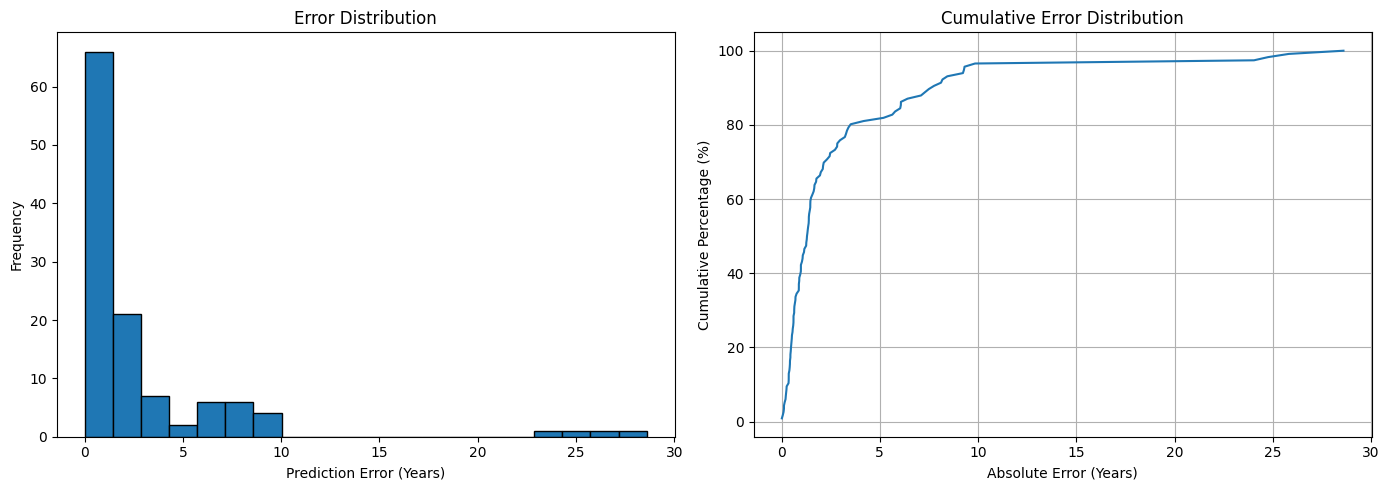

MAE: 3.75
RMSE: 6.08
R2: 0.08
MAPE: 21.97
Within ±2 Years (%): 41.38
Within ±5 Years (%): 80.17
Within ±10 Years (%): 96.55
Max Error: 29.26
Median Error: 2.30
Cumulative Error ≤ 5 Years (%): 80.17


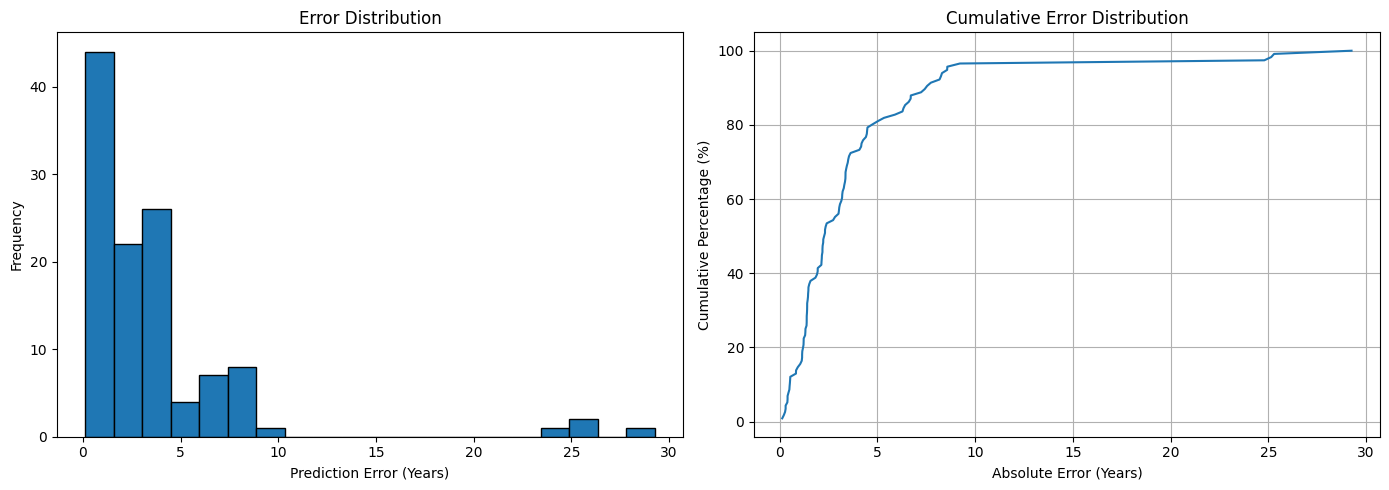

MAE: 2.90
RMSE: 5.83
R2: 0.15
MAPE: 15.85
Within ±2 Years (%): 68.10
Within ±5 Years (%): 81.90
Within ±10 Years (%): 96.55
Max Error: 29.62
Median Error: 1.19
Cumulative Error ≤ 5 Years (%): 81.90


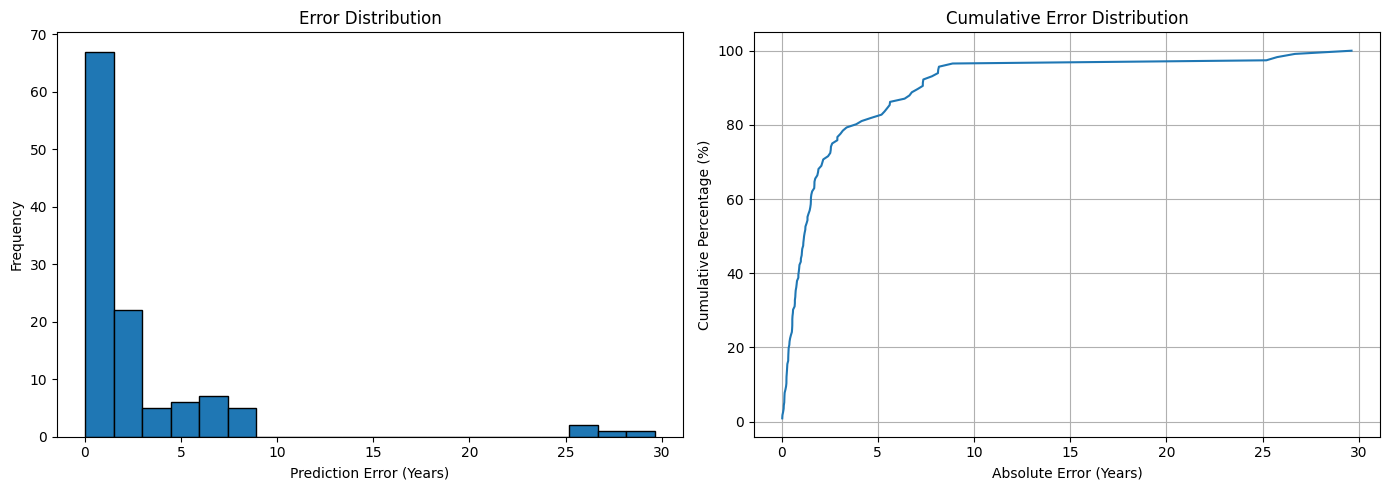

MAE: 3.14
RMSE: 5.88
R2: 0.14
MAPE: 17.71
Within ±2 Years (%): 55.17
Within ±5 Years (%): 81.03
Within ±10 Years (%): 96.55
Max Error: 29.54
Median Error: 1.36
Cumulative Error ≤ 5 Years (%): 81.03


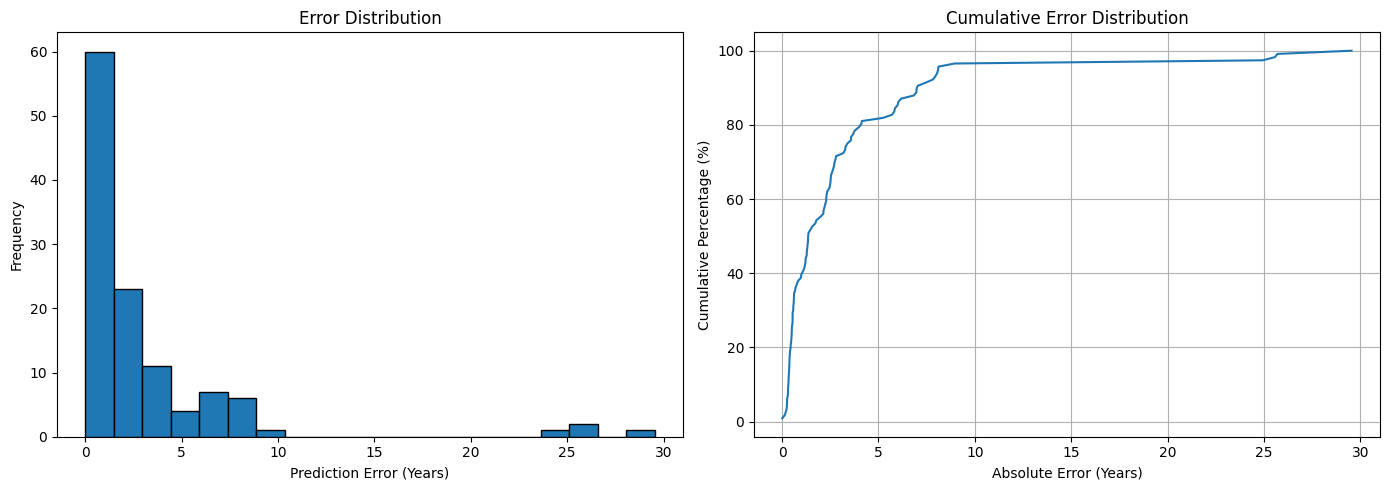

MAE: 2.85
RMSE: 5.87
R2: 0.14
MAPE: 15.30
Within ±2 Years (%): 68.97
Within ±5 Years (%): 84.48
Within ±10 Years (%): 96.55
Max Error: 30.11
Median Error: 1.26
Cumulative Error ≤ 5 Years (%): 84.48


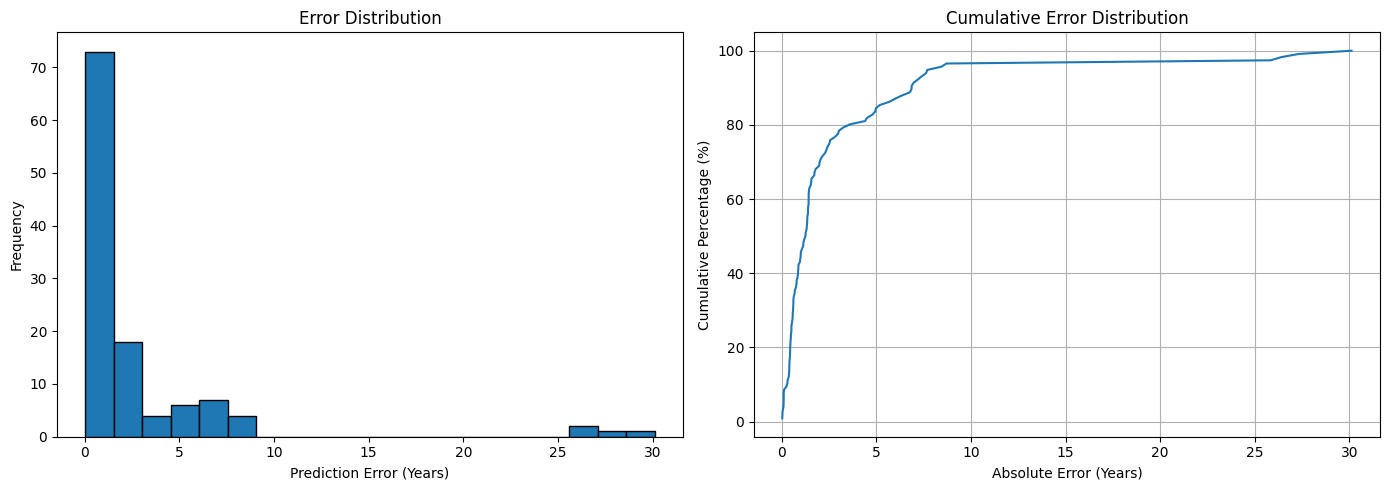

MAE: 2.86
RMSE: 5.86
R2: 0.14
MAPE: 15.48
Within ±2 Years (%): 68.10
Within ±5 Years (%): 82.76
Within ±10 Years (%): 96.55
Max Error: 30.08
Median Error: 1.21
Cumulative Error ≤ 5 Years (%): 82.76


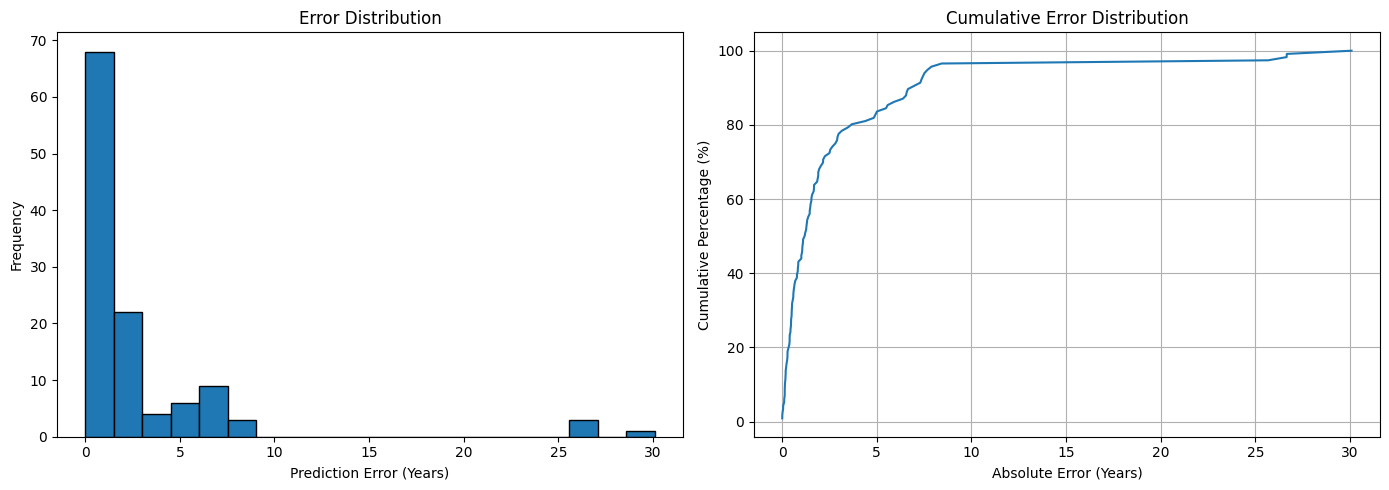

MAE: 3.24
RMSE: 6.04
R2: 0.09
MAPE: 18.17
Within ±2 Years (%): 56.90
Within ±5 Years (%): 81.90
Within ±10 Years (%): 96.55
Max Error: 30.80
Median Error: 1.58
Cumulative Error ≤ 5 Years (%): 81.90


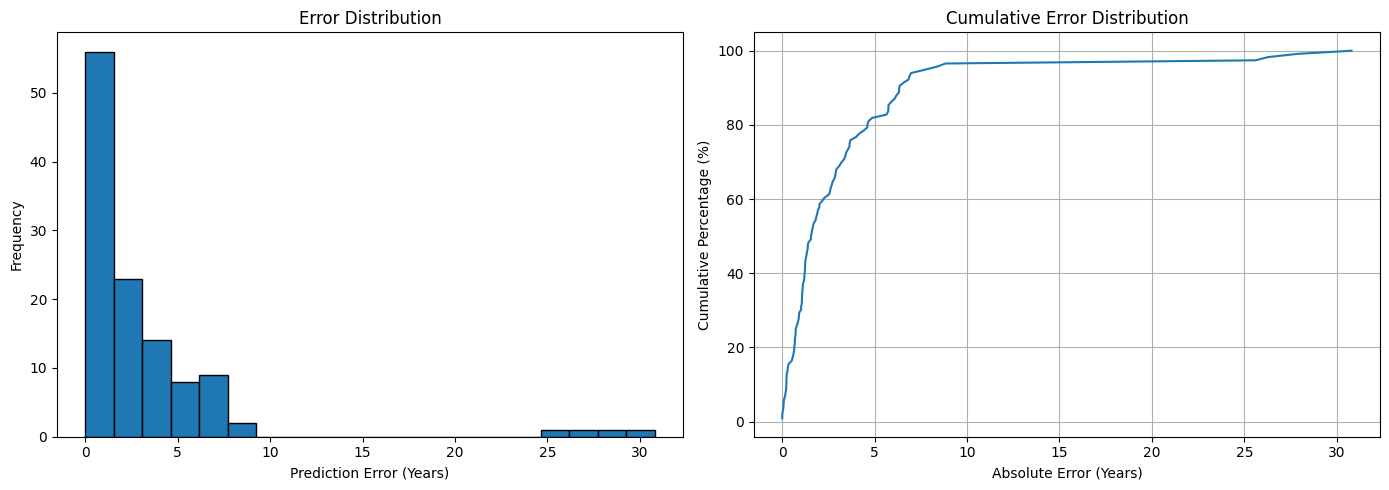

MAE: 3.35
RMSE: 6.14
R2: 0.06
MAPE: 18.61
Within ±2 Years (%): 53.45
Within ±5 Years (%): 82.76
Within ±10 Years (%): 96.55
Max Error: 31.55
Median Error: 1.69
Cumulative Error ≤ 5 Years (%): 82.76


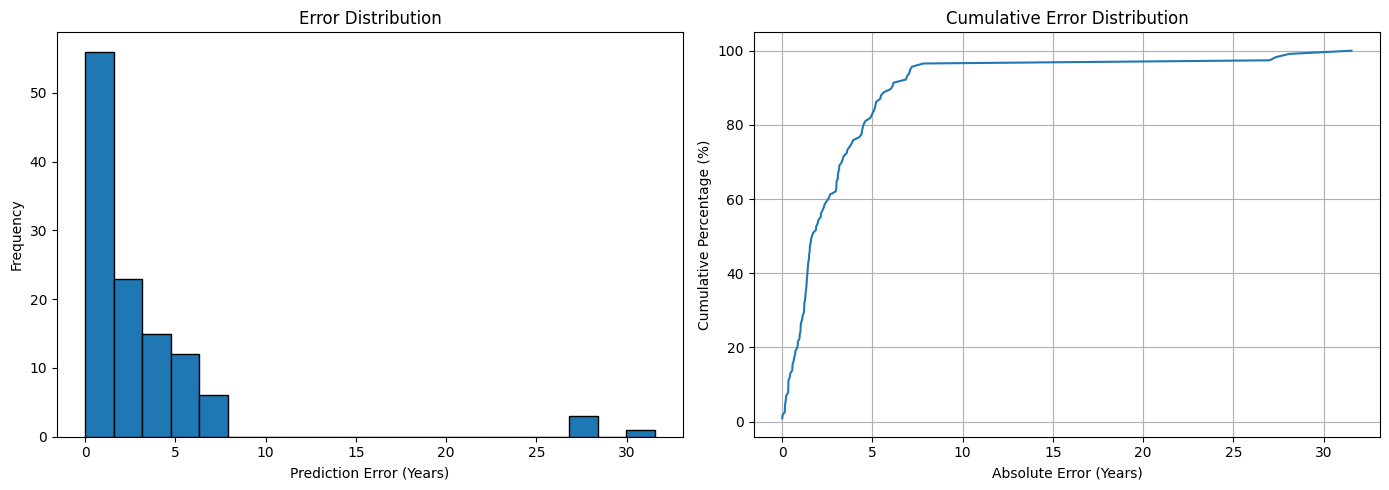

  Ensemble Group       Method  \
0  Full Ensemble  Grid Search   
1  Full Ensemble    MAE-based   
2         Best 4  Grid Search   
3         Best 4    MAE-based   
4         Best 3  Grid Search   
5         Best 3    MAE-based   
6         Best 2  Grid Search   
7         Best 2    MAE-based   

                                             Weights   MAE  RMSE    R2  \
0  {'ResNet50': 0.1, 'InceptionV3': 0.1, 'Incepti...  3.01  5.81  0.16   
1  {'ResNet50': 0.21499783268313827, 'InceptionV3...  3.75  6.08  0.08   
2  {'ResNet50': 0.1, 'InceptionResNetV2': 0.4, 'D...  2.90  5.83  0.15   
3  {'ResNet50': 0.26561844863731654, 'InceptionRe...  3.14  5.88  0.14   
4  {'ResNet50': 0.1, 'InceptionResNetV2': 0.5, 'D...  2.85  5.87  0.14   
5  {'ResNet50': 0.35101476014760147, 'InceptionRe...  2.86  5.86  0.14   
6        {'ResNet50': 0.9, 'InceptionResNetV2': 0.1}  3.24  6.04  0.09   
7  {'ResNet50': 0.529839883551674, 'InceptionResN...  3.35  6.14  0.06   

   MAPE (%)  Within ±2 Years (%)  W

In [ ]:
import numpy as np
import pandas as pd

# ----------------------------
# Assume these helper objects/functions are already defined:
# - pivot_df: DataFrame with one row per image, columns: 'ImageID' and each model's prediction.
# - true_age_dict: Dictionary mapping ImageID (from labels_data['File']) to true age.
# - ensemble_groups: Dictionary mapping group name -> list of model names (e.g. Full Ensemble, Best 4, etc.).
# - weighted_ensemble_from_row(row, weights, group_models): returns weighted prediction for that row.
# - compute_evaluation_metrics(true_images, predicted_images): returns a dict with keys like:
#       "MAE", "RMSE", "R2", "MAPE", "Within ±2 Years (%)", "Within ±5 Years (%)",
#       "Within ±10 Years (%)", "Max Error", "Median Error", "Cumulative Error ≤ 5 Years (%)", ...
# ----------------------------

# Hard-coded best weights (from your final output) for each ensemble group.
best_weights = {
    'Full Ensemble': {
         'Grid Search': {'ResNet50': 0.1, 'InceptionV3': 0.1, 'InceptionResNetV2': 0.2, 'DenseNet121': 0.5, 'EfficientNetV2M': 0.1},
         'MAE-based': {'ResNet50': 0.21499783268313827, 'InceptionV3': 0.19516688339835286, 'InceptionResNetV2': 0.21055483311660164, 'DenseNet121': 0.2069787602947551, 'EfficientNetV2M': 0.17230169050715216}
    },
    'Best 4': {
         'Grid Search': {'ResNet50': 0.1, 'InceptionResNetV2': 0.4, 'DenseNet121': 0.4, 'InceptionV3': 0.1},
         'MAE-based': {'ResNet50': 0.26561844863731654, 'InceptionResNetV2': 0.25702306079664566, 'DenseNet121': 0.250104821802935, 'InceptionV3': 0.22725366876310274}
    },
    'Best 3': {
         'Grid Search': {'ResNet50': 0.1, 'InceptionResNetV2': 0.5, 'DenseNet121': 0.4},
         'MAE-based': {'ResNet50': 0.35101476014760147, 'InceptionResNetV2': 0.33210332103321033, 'DenseNet121': 0.31688191881918815}
    },
    'Best 2': {
         'Grid Search': {'ResNet50': 0.9, 'InceptionResNetV2': 0.1},
         'MAE-based': {'ResNet50': 0.529839883551674, 'InceptionResNetV2': 0.47016011644832606}
    }
}

def evaluate_ensemble(weights, group_models, pivot_df, true_age_dict):
    """
    Computes ensemble predictions for each image using the given weights and returns evaluation metrics.
    """
    df_temp = pivot_df.copy()
    # Compute weighted ensemble predictions per image.
    df_temp['Ensemble_Prediction'] = df_temp.apply(
        lambda row: weighted_ensemble_from_row(row, weights, group_models), axis=1
    )
    df_temp = df_temp.dropna(subset=['Ensemble_Prediction'])

    # Gather predictions and true values.
    y_true, y_pred = [], []
    for _, row in df_temp.iterrows():
        image_id = row['ImageID']
        if image_id in true_age_dict:
            y_true.append(true_age_dict[image_id])
            y_pred.append(row['Ensemble_Prediction'])

    # Compute metrics using your evaluation function.
    metrics = compute_evaluation_metrics(np.array(y_true), np.array(y_pred))
    return metrics

###############################################################################
# Build a summary table that includes all metrics from compute_evaluation_metrics.
###############################################################################

results_summary = []

for group_name, group_models in ensemble_groups.items():
    # For each method (Grid Search and MAE-based) in that group
    for method, weights in best_weights[group_name].items():
        # Evaluate the ensemble
        metrics = evaluate_ensemble(weights, group_models, pivot_df, true_age_dict)

        # Build row data with group, method, weights and all metrics
        row_data = {
            "Ensemble Group": group_name,
            "Method": method,
            "Weights": str(weights)  # convert weights dict to string for clarity
        }
        # Rename "MAPE" to "MAPE (%)" if present, and add all metrics
        for k, v in metrics.items():
            if k == "MAPE":
                row_data["MAPE (%)"] = v
            else:
                row_data[k] = v
        results_summary.append(row_data)

# Convert to a DataFrame.
summary_df = pd.DataFrame(results_summary)

# Reorder columns for clarity.
ordered_cols = [
    "Ensemble Group", "Method", "Weights",
    "MAE", "RMSE", "R2", "MAPE (%)",
    "Within ±2 Years (%)", "Within ±5 Years (%)", "Within ±10 Years (%)",
    "Max Error", "Median Error", "Cumulative Error ≤ 5 Years (%)"
]
final_cols = [c for c in ordered_cols if c in summary_df.columns]
summary_df = summary_df[final_cols]

# Round all numeric columns to 2 decimals.
def round_numeric_columns(df, decimals=2):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].round(decimals)
    return df

summary_df = round_numeric_columns(summary_df, decimals=2)

# Print the summary in the notebook.
print(summary_df)

# Save to CSV.
csv_output_path = "ensemble_evaluation_summary.csv"
summary_df.to_csv(csv_output_path, index=False)
print("\nFinal evaluation summary saved to:", csv_output_path)